# Detecci√≥n de neumon√≠a
#### Proyecto: AIRE
#### - Luis Carlos Romero Cardenas.
#### - Maria Camila Plazas G√≥mez.
#### - Alejandra G√≥mez.
#### - Efra√≠n Santiago Mayorga Chaves. 

## 1. Importar datos

In [1]:
!pip install kagglehub

Solo ejecutar si se requiere descargar las im√°genes desde Kaggle

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.29G/2.29G [08:33<00:00, 4.80MB/s]

Extracting files...


Path to dataset files: C:\Users\Luis Romero\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


### 1.1. Importar librerias

In [2]:
#!pip uninstall numpy -y
#!pip uninstall pandas numpy -y
!pip install numpy==1.26.4 pandas==2.2.2 tensorflow==2.16.1 scikit-learn matplotlib mlflow


  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached waitress-3.0.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl.metadata (12 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------  11.5/11.6 MB 65.9 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 45.4 MB/s eta 0:00:00
   ---------------------------------------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.6.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
jaxlib 0.6.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.


### üì¶ Instalaci√≥n de librer√≠as

Se instalan versiones espec√≠ficas para asegurar **compatibilidad** y **reproducibilidad** del proyecto:

- **`numpy==1.26.4`**: Versi√≥n moderna y estable, compatible con TensorFlow y otras librer√≠as.
- **`pandas==2.2.2`**: Eficiente para manipular datos tabulares como etiquetas o rutas de im√°genes.
- Las versiones est√°n fijadas para evitar **errores de compatibilidad** y asegurar que el c√≥digo funcione igual en cualquier entorno.




In [1]:
#librerias est√°ndar
import os
from collections import Counter

#librerias de manejo de datos
import pandas as pd
import numpy as np

#librerias de deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121


#librerias de visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [2]:

# Ruta completa al conjunto de datos
path=''
data_dir = os.path.join(path, 'Data', 'chest_xray')
data_dir

# Cargar las im√°genes desde las carpetas train, test y val
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Crear datasets para train, test y val
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    #shuffle=True 
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False 
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),
    batch_size=32
)

print("Datasets cargados exitosamente.")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Datasets cargados exitosamente.


###  Carga del dataset de radiograf√≠as

Se define la ruta del conjunto de datos `chest_xray`, que contiene tres subdirectorios: **train**, **test** y **val**. Cada uno incluye im√°genes de radiograf√≠as clasificadas en dos clases: `NORMAL` y `PNEUMONIA`.

Luego, se crean datasets de TensorFlow a partir de estas carpetas usando `image_dataset_from_directory`, que permite cargar y etiquetar autom√°ticamente las im√°genes seg√∫n su carpeta.

- **Tama√±o de imagen**: 256x256 p√≠xeles
- **Tama√±o de lote**: 32 im√°genes por batch
- **`shuffle=False`** en el conjunto de prueba para mantener el orden

>  Esta estructura es com√∫n en tareas de clasificaci√≥n de im√°genes, ya que facilita el entrenamiento y la evaluaci√≥n de modelos con Keras.


### 1.2 Determinar el tama√±o original de las im√°genes.

In [3]:
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

# Mostrar dimensiones originales de las primeras 5 im√°genes
for path in image_paths[:5]:
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_image(img_raw)
    print(f"{os.path.basename(path)}: {img.shape}")

IM-0115-0001.jpeg: (1858, 2090, 1)
IM-0117-0001.jpeg: (1152, 1422, 1)
IM-0119-0001.jpeg: (1434, 1810, 1)
IM-0122-0001.jpeg: (1279, 1618, 1)
IM-0125-0001.jpeg: (1125, 1600, 1)



### Exploraci√≥n inicial de las im√°genes

Debido al tama√±o de promedio de cada imagen y que podr√≠a impactar el rendimiento en el entrenamiento del modelo se har√° un reescalado de cada imagen a un tama√±o estandar de 256 x 256 pixels. Adicional, se evidencia que son im√°genes en escala de grises


Se recorren las carpetas del conjunto de entrenamiento (`train_dir`) para:

- Obtener las rutas de todas las im√°genes con extensiones comunes (`.jpg`, `.jpeg`, `.png`)
- Mostrar las **dimensiones originales** (alto, ancho, canales) de las primeras 5 im√°genes

Esto permite entender mejor la **variabilidad en tama√±os** de las im√°genes antes de aplicar transformaciones o preprocesamiento.

> üñºÔ∏è Verificar las dimensiones originales es √∫til para decidir si es necesario redimensionar o normalizar las im√°genes de forma consistente.



Cada l√≠nea muestra el **nombre del archivo** y su forma `(alto, ancho, canales)`:

- Los valores indican que las im√°genes tienen **resoluciones variables**, lo cual es com√∫n en datasets m√©dicos.
- El tercer valor (`1`) representa que las im√°genes son en **escala de grises** (un solo canal).

> üñºÔ∏è Esta inspecci√≥n es clave para decidir si se deben redimensionar y convertir las im√°genes a un formato est√°ndar antes de usarlas en un modelo.


### 1.3. Muestra de los datos

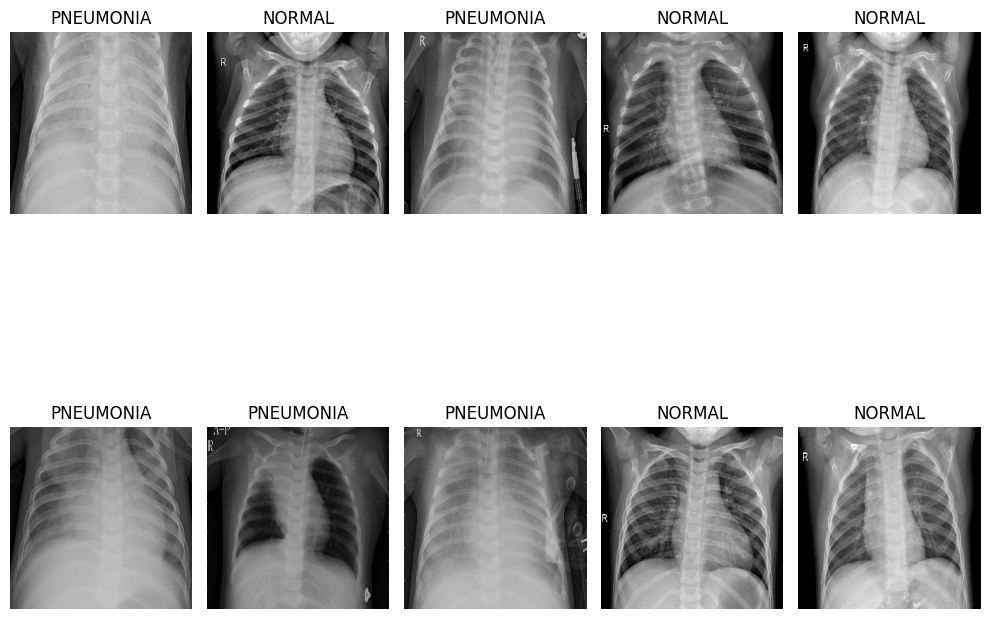

In [4]:

# Obtener las clases del conjunto de entrenamiento
class_names = train_dataset.class_names

# Inicializar contadores para las categor√≠as
category_counts = {class_name: 0 for class_name in class_names}
max_images_per_category = 5

# Crear una lista para almacenar las im√°genes y etiquetas
images_to_plot = []
labels_to_plot = []

# Iterar sobre el conjunto de entrenamiento
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if category_counts[class_name] < max_images_per_category:
            images_to_plot.append(image)
            labels_to_plot.append(class_name)
            category_counts[class_name] += 1
        # Romper el bucle si ya tenemos suficientes im√°genes
        if all(count >= max_images_per_category for count in category_counts.values()):
            break
    if all(count >= max_images_per_category for count in category_counts.values()):
        break

# Graficar las im√°genes
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(images_to_plot, labels_to_plot)):
    plt.subplot(2, max_images_per_category, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

###  Visualizaci√≥n de im√°genes por categor√≠a

Esta celda permite **visualizar ejemplos representativos** de cada clase del conjunto de entrenamiento.

####  ¬øQu√© hace el c√≥digo?

- Obtiene las **clases** detectadas en `train_dataset` (`NORMAL` y `PNEUMONIA`).
- Selecciona hasta **5 im√°genes por clase** para graficarlas.
- Recorre el dataset por lotes y guarda im√°genes junto a sus etiquetas hasta alcanzar el l√≠mite por clase.
- Finalmente, muestra las im√°genes en un **grid organizado**, con su clase como t√≠tulo.

####  ¬øPor qu√© es √∫til?

- Permite una **inspecci√≥n visual r√°pida** de los datos, ideal para confirmar que las im√°genes est√°n bien cargadas y etiquetadas.
- Ayuda a entender diferencias visuales entre clases y a detectar posibles errores en el dataset.

>  Esta pr√°ctica es clave en visi√≥n por computadora para familiarizarse con la distribuci√≥n visual del conjunto de datos antes del entrenamiento.


# 2. Preprocesar Datos

### 2.1. Determinar las caracter√≠sticas del conjunto de datos:


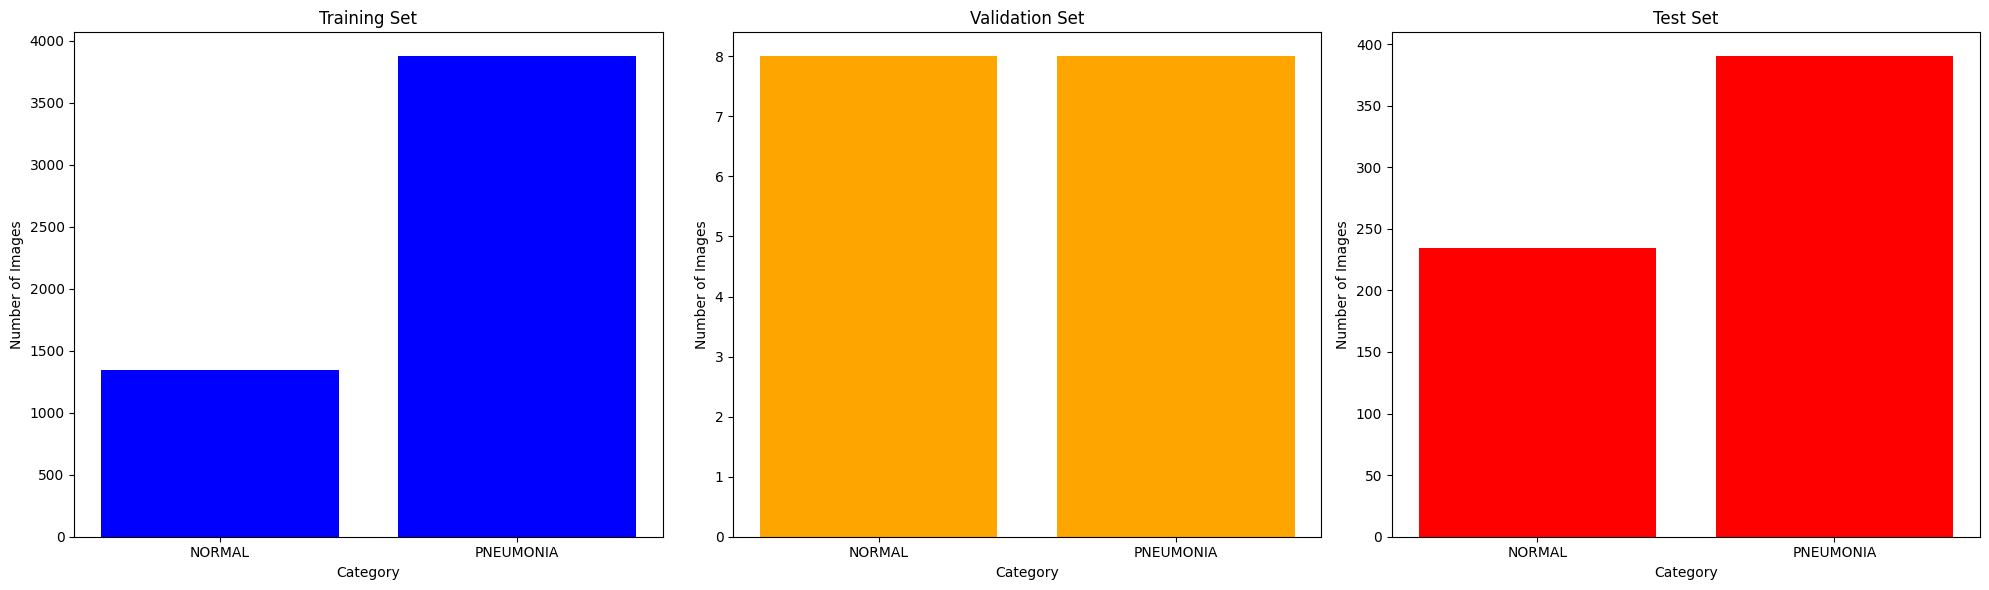

N√∫mero de im√°genes por categor√≠a en el conjunto de entrenamiento: [1341 3875]
N√∫mero de im√°genes por categor√≠a en el conjunto de validaci√≥n: [8 8]
N√∫mero de im√°genes por categor√≠a en el conjunto de prueba: [234 390]


In [5]:
categories = train_dataset.class_names

# Funci√≥n para contar las ocurrencias por clase
def count_labels(dataset, num_classes):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    counts = np.bincount(all_labels, minlength=num_classes)
    return counts

# Obtener los conteos
num_classes = len(categories)
train_counts = count_labels(train_dataset, num_classes)
val_counts = count_labels(val_dataset, num_classes)
test_counts = count_labels(test_dataset, num_classes)

# Crear una figura y ejes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Gr√°ficos
ax[0].bar(categories, train_counts, color='blue')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Images')

ax[1].bar(categories, val_counts, color='orange')
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Images')

ax[2].bar(categories, test_counts, color='red')
ax[2].set_title('Test Set')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

print("N√∫mero de im√°genes por categor√≠a en el conjunto de entrenamiento:", train_counts)
print("N√∫mero de im√°genes por categor√≠a en el conjunto de validaci√≥n:", val_counts)
print("N√∫mero de im√°genes por categor√≠a en el conjunto de prueba:", test_counts)

###  Distribuci√≥n de clases en los datasets

Esta celda analiza cu√°ntas im√°genes hay por categor√≠a (**`NORMAL`** y **`PNEUMONIA`**) en cada subconjunto: **entrenamiento**, **validaci√≥n** y **prueba**.

####  ¬øQu√© hace el c√≥digo?

- Define una funci√≥n `count_labels()` que recorre los datasets y cuenta cu√°ntas veces aparece cada clase.
- Aplica esta funci√≥n a los tres conjuntos: `train_dataset`, `val_dataset` y `test_dataset`.
- Visualiza los resultados mediante tres gr√°ficos de barras, uno por conjunto.

####  Ejemplo de salida (resumen impreso):
Se logra evidenciar un desbalanceo del tama√±o por cada categor√≠a, en los conjuntos de entrenamiento y prueba. Lo que reuiqre aplicar t√©cnicas para el manejar el desbalanceo y que no afecte el entrenamiento.

<hr style="height:3px; background-color:white; border:none;" />



####  Observaciones:

- El conjunto de **entrenamiento** est√° **desbalanceado**, con muchas m√°s im√°genes de `PNEUMONIA` que de `NORMAL`.
- El conjunto de **validaci√≥n** tiene muy pocas im√°genes (solo **8 por clase**), lo cual puede ser insuficiente para una evaluaci√≥n robusta.
- El conjunto de **prueba** tiene una distribuci√≥n similar al de entrenamiento, aunque m√°s equilibrada.

> ‚ö†Ô∏è Este tipo de desbalance puede afectar el aprendizaje del modelo y requiere estrategias como **ponderar las clases**, **aumentar los datos** o **usar m√©tricas adecuadas** (como F1-score o AUC).


### 2.2. Aplicar la t√©cnica de aumento de datos para el conjunto de datos de entrenamiento √∫nicamente:

In [125]:
# Aumento de datos definido como un modelo secuencial
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.08),
])

# Cargar dataset desde carpeta
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32
)

# Aplicar el aumento de datos solo al entrenamiento
# (no lo aplicamos a validaci√≥n ni prueba)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 5216 files belonging to 2 classes.


###  Aumento de datos (Data Augmentation)

Para mejorar la **generalizaci√≥n del modelo** y reducir el sobreajuste, se aplica **aumento de datos** (data augmentation) al conjunto de entrenamiento.

####  ¬øQu√© hace el c√≥digo?

- Se define una secuencia de transformaciones aleatorias usando `tf.keras.Sequential`, incluyendo:
  - **Flip horizontal** (`RandomFlip`): invierte la imagen lateralmente.
  - **Rotaci√≥n** (`RandomRotation`): rota ligeramente la imagen.
  - **Zoom** (`RandomZoom`): acerca o aleja ligeramente.
  - **Traslaci√≥n** (`RandomTranslation`): mueve la imagen horizontal y verticalmente.
  - **Contraste** (`RandomContrast`): var√≠a la intensidad de contraste.

- Luego, se vuelve a cargar el dataset de entrenamiento y se aplica la transformaci√≥n con `map()`, manteniendo las etiquetas originales.

>  Estas transformaciones se aplican **solo durante el entrenamiento**, para simular mayor variedad de im√°genes y ayudar al modelo a aprender caracter√≠sticas m√°s robustas.

>  No se aplican al conjunto de validaci√≥n ni prueba, ya que esas fases requieren datos sin alterar para evaluar el rendimiento real del modelo.


<hr style="height:3px; background-color:white; border:none;" />

## Salida


Esto confirma que el conjunto de entrenamiento contiene **5216 im√°genes** distribuidas entre las dos clases (`NORMAL` y `PNEUMONIA`).

>  Las transformaciones se aplican **solo durante el entrenamiento**, permitiendo al modelo ver versiones ligeramente distintas de las im√°genes en cada √©poca, lo que ayuda a aprender de forma m√°s robusta.


# 3. Modelo 
### 3.1. Definir par√°metros del modelo:

In [6]:
size_filter=(3, 3)
input_shape = (256, 256, 3)
size_classes = len(class_names)
epochs = 30
batch_size = 32
val_image_count = sum([len(files) for r, d, files in os.walk(val_dir) if files])
validation_steps=val_image_count//batch_size
train_image_count = sum([len(files) for r, d, files in os.walk(train_dir) if files])
train_steps=train_image_count//batch_size
test_image_count = sum([len(files) for r, d, files in os.walk(test_dir) if files])
test_steps=test_image_count//batch_size
labels_names = ['NORMAL', 'PNEUMONIA']

###  Definici√≥n de par√°metros y configuraci√≥n inicial

Se definen par√°metros clave para la configuraci√≥n del modelo y la preparaci√≥n del entrenamiento:

- **`size_filter = (3, 3)`**: Tama√±o del filtro que se usar√° en las capas convolucionales.
- **`input_shape = (256, 256, 3)`**: Tama√±o de entrada de las im√°genes (ancho, alto, canales RGB). Aunque las im√°genes originales son en escala de grises, se procesan como si tuvieran 3 canales para ser compatibles con modelos est√°ndar de Keras.
- **`size_classes = len(class_names)`**: N√∫mero de clases detectadas (`NORMAL`, `PNEUMONIA`).

####  Hiperpar√°metros del entrenamiento:

- **`epochs = 30`**: N√∫mero de √©pocas de entrenamiento.
- **`batch_size = 32`**: Tama√±o del lote.

####  C√°lculo de pasos por √©poca (steps per epoch):

Se calcula cu√°ntas veces hay que iterar por conjunto para cubrir todos los datos:

- **`train_steps`** = total de im√°genes de entrenamiento dividido por `batch_size`
- **`validation_steps`** = total de im√°genes de validaci√≥n dividido por `batch_size`
- **`test_steps`** = total de im√°genes de prueba dividido por `batch_size`

Esto es √∫til para los m√©todos `.fit()` y `.evaluate()` del modelo.

####  Etiquetas:

- **`labels_names = ['NORMAL', 'PNEUMONIA']`**: Lista expl√≠cita de nombres de clases, √∫til para interpretar predicciones o visualizar resultados.

> ‚úÖ Esta configuraci√≥n prepara el entorno para entrenar de forma controlada y reproducible.


### 3.2 Definir el modelo de CNN

In [41]:
model = models.Sequential([
    layers.Conv2D(32,size_filter , activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # A√±adir Dropout con una tasa del 50%
    layers.Dense(size_classes, activation='softmax')
])


###  Definici√≥n del modelo CNN (Red Neuronal Convolucional)

Se construye un modelo secuencial (`Sequential`) utilizando **capas convolucionales** para el reconocimiento de im√°genes de rayos X con y sin neumon√≠a.

####  Arquitectura del modelo:

1. **`Conv2D(32, (3, 3), activation='relu')`**  
   - 32 filtros con tama√±o 3√ó3  
   - Activaci√≥n ReLU  
   - Regularizaci√≥n L2 (`l2(0.001)`) para evitar sobreajuste  
   - Primera capa: define la forma de entrada `input_shape=(256, 256, 3)`

2. **`MaxPooling2D((2, 2))`**  
   - Reduce la resoluci√≥n espacial a la mitad  
   - Conserva caracter√≠sticas importantes

3. **`Conv2D(64, (3, 3), activation='relu')` + `MaxPooling2D`**  
   - Segunda capa convolucional con m√°s filtros (64) para capturar patrones m√°s complejos

4. **`Conv2D(128, (3, 3), activation='relu')` + `MaxPooling2D`**  
   - Tercera capa convolucional con 128 filtros  
   - Extrae caracter√≠sticas de alto nivel

5. **`Flatten()`**  
   - Convierte la salida 2D en un vector 1D para conectarse a capas densas

6. **`Dense(128, activation='relu')`**  
   - Capa totalmente conectada  
   - Tambi√©n incluye regularizaci√≥n L2

7. **`Dropout(0.5)`**  
   - Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento  
   - Reduce el riesgo de sobreajuste

8. **`Dense(size_classes, activation='softmax')`**  
   - Capa de salida con tantas neuronas como clases (`2`)  
   - Softmax convierte la salida en probabilidades

> ‚úÖ Esta arquitectura es adecuada para tareas de clasificaci√≥n de im√°genes y est√° dise√±ada para **prevenir el sobreajuste** mediante regularizaci√≥n y dropout.


### 3.3. Compilar el modelo

In [44]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[
                  'accuracy',
                  metrics.Precision(name='precision'),
                  metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_6 (Conv2D)               ‚îÇ (None, 254, 254, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_6 (MaxPooling2D)  ‚îÇ (None, 127, 127, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_7 (Conv2D)               ‚îÇ (None, 125, 125, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_7 (MaxPooling2D)  ‚îÇ (None, 62, 62, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_8 (Conv2D)               ‚îÇ (None, 60, 60, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_8 (MaxPooling2D)  ‚îÇ (None, 30, 30, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)             ‚îÇ (None, 115200)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 128)            ‚îÇ    14,745,728 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           258 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

###  Compilaci√≥n del modelo

Una vez definida la arquitectura, se **compila** el modelo indicando el optimizador, la funci√≥n de p√©rdida y las m√©tricas a evaluar durante el entrenamiento.

####  Par√°metros de compilaci√≥n:

- **`optimizer='adam'`**  
  Utiliza el optimizador **Adam**, muy popular por su eficiencia y buen rendimiento en la mayor√≠a de los problemas de deep learning.

- **`loss='sparse_categorical_crossentropy'`**  
  Funci√≥n de p√©rdida usada para clasificaci√≥n **multiclase** con etiquetas enteras.  
  *(Ideal cuando las clases est√°n codificadas como 0 y 1 en lugar de one-hot)*

- **`metrics=[...]`**  
  Se monitorean varias m√©tricas:
  - **`accuracy`**: exactitud general
  - **`precision`**: proporci√≥n de verdaderos positivos entre todas las predicciones positivas
  - **`recall`**: proporci√≥n de verdaderos positivos entre todos los casos reales positivos

####  `model.summary()`

Muestra un resumen estructurado del modelo, incluyendo:
- El nombre y tipo de cada capa
- El n√∫mero de par√°metros entrenables
- El tama√±o de salida de cada capa

> ‚úÖ Esta configuraci√≥n es adecuada para tareas de clasificaci√≥n de im√°genes con dos clases, y permite evaluar el modelo no solo por precisi√≥n general, sino tambi√©n por c√≥mo se comporta en t√©rminos de errores tipo I y II.


<hr style="height:3px; background-color:white; border:none;" />

## Salida

###  Resumen del modelo (`model.summary()`)

A continuaci√≥n, se detalla la arquitectura del modelo entrenado para clasificar radiograf√≠as de t√≥rax en dos clases: **NORMAL** y **PNEUMONIA**.

####  Estructura del modelo convolucional:

| Capa | Tipo | Dimensiones de salida | Par√°metros | Descripci√≥n |
|------|------|------------------------|------------|-------------|
| `Conv2D` | Convolucional (32 filtros, 3x3) | (254, 254, 32) | 896 | Extrae caracter√≠sticas locales como bordes y texturas |
| `MaxPooling2D` | Submuestreo | (127, 127, 32) | 0 | Reduce la resoluci√≥n y el c√≥mputo |
| `Conv2D` | Convolucional (64 filtros) | (125, 125, 64) | 18,496 | Aprende patrones m√°s complejos |
| `MaxPooling2D` | Submuestreo | (62, 62, 64) | 0 | Reducci√≥n adicional de resoluci√≥n |
| `Conv2D` | Convolucional (128 filtros) | (60, 60, 128) | 73,856 | Extrae caracter√≠sticas de alto nivel |
| `MaxPooling2D` | Submuestreo | (30, 30, 128) | 0 | Preparaci√≥n para capa densa |
| `Flatten` | Reestructuraci√≥n | (115200,) | 0 | Convierte mapas de activaci√≥n en vector |
| `Dense` | Capa totalmente conectada (128) | (128,) | 14,745,728 | Aprende combinaciones complejas de caracter√≠sticas |
| `Dropout(0.5)` | Regularizaci√≥n | (128,) | 0 | Previene el sobreajuste apagando el 50% de neuronas |
| `Dense` | Capa de salida (2 clases) | (2,) | 258 | Predice clase final con activaci√≥n softmax |

####  Par√°metros totales:
- **Total de par√°metros**: `14,839,234` (~56.6 MB)
- **Entrenables**: `100%` del total
- **No entrenables**: `0`

> ‚úÖ La mayor√≠a de los par√°metros est√°n en la **capa densa** intermedia (`Dense(128)`), ya que recibe una entrada muy grande tras el `Flatten`.

Este modelo est√° optimizado para clasificar im√°genes m√©dicas en dos clases con **alta capacidad de aprendizaje**, pero tambi√©n incluye mecanismos para reducir el sobreajuste como la **regularizaci√≥n L2** y el **Dropout**.


### 3.4.  Entrenar el modelo

In [45]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 192s 1s/step - accuracy: 0.6957 - loss: 28.9797 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 3/30


c:\ProgramData\anaconda3\envs\mlops\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 179s 1s/step - accuracy: 0.7857 - loss: 0.8373 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 186s 1s/step - accuracy: 0.7774 - loss: 0.8026 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 6/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 7/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 181s 1s/step - accuracy: 0.7782 - loss: 1.0276 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 8/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.

### 3.4. Evaluar el modelo en el conjunto de prueba

In [56]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 223ms/step - accuracy: 0.4135 - loss: 1.3995
Test accuracy: 0.6682692170143127


###  Evaluaci√≥n del modelo en el conjunto de prueba

Una vez entrenado, se eval√∫a el rendimiento del modelo usando el conjunto de **prueba**, que contiene im√°genes **nunca vistas** durante el entrenamiento ni la validaci√≥n.


###  Interpretaci√≥n de los resultados de prueba

Tras evaluar el modelo sobre el conjunto de **prueba**, se obtuvieron los siguientes resultados:

- **P√©rdida (`loss`)**: `1.3995`
- **Precisi√≥n (`accuracy`)**: `66.83%`

####  ¬øQu√© significa esto?

- La precisi√≥n indica que el modelo clasific√≥ correctamente cerca del **67%** de las radiograf√≠as no vistas.  
- Sin embargo, el valor de **p√©rdida elevado** sugiere que el modelo tiene **incertidumbre o errores significativos** en sus predicciones.
- Puede deberse a:
  - Un **modelo sobreajustado** (overfitting) al conjunto de entrenamiento.
  - Un posible **desequilibrio de clases** (por ejemplo, m√°s casos de neumon√≠a que normales).
  - La arquitectura actual podr√≠a no ser lo suficientemente profunda o generalizable.

>  En aplicaciones m√©dicas, una precisi√≥n del **67% puede no ser aceptable**, especialmente si se desea minimizar falsos negativos (no detectar neumon√≠a cuando s√≠ est√° presente).



### 3.5 M√©tricas

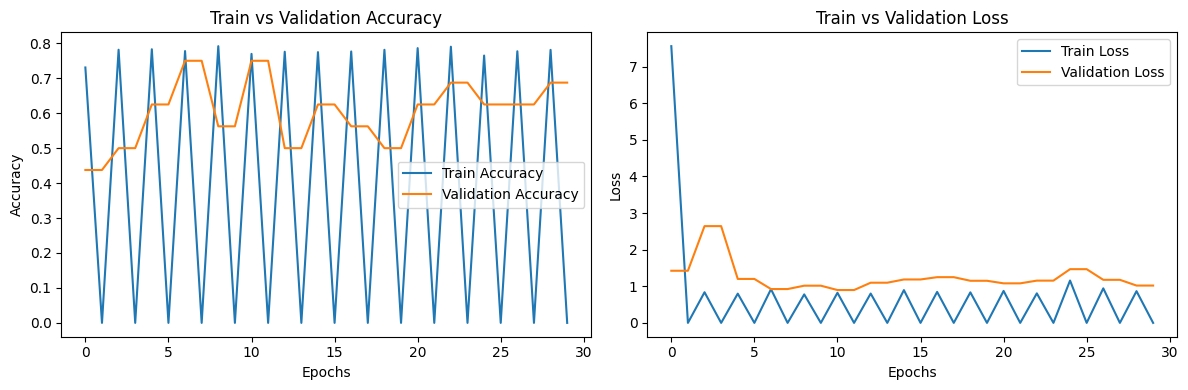

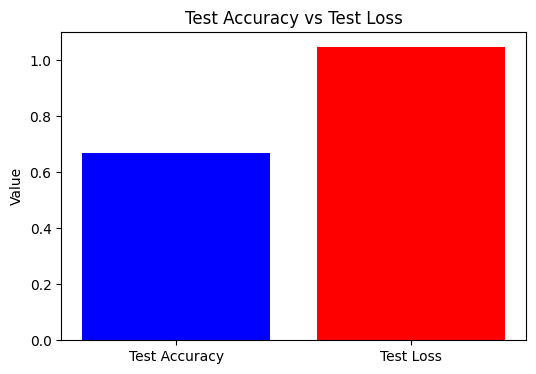

In [57]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


###  An√°lisis de Rendimiento del Modelo

####  Entrenamiento vs Validaci√≥n

**1. Precisi√≥n (`Accuracy`)**
- La curva de **entrenamiento** muestra una oscilaci√≥n muy pronunciada, indicando una posible inestabilidad en el aprendizaje.
- La **precisi√≥n de validaci√≥n** se mantiene mucho m√°s estable y alcanza un valor m√°ximo de ~0.75, aunque sin una tendencia clara de mejora.
- Esto sugiere que el modelo no est√° aprendiendo de forma constante y probablemente est√© **sobreajust√°ndose** a los datos de entrenamiento.

**2. P√©rdida (`Loss`)**
- La p√©rdida de entrenamiento desciende con oscilaciones, pero se mantiene baja.
- La p√©rdida de validaci√≥n es mucho m√°s estable y no mejora significativamente despu√©s de las primeras √©pocas.
- Esta divergencia entre la p√©rdida de entrenamiento y validaci√≥n es un indicio claro de **overfitting**.

---

####  Desempe√±o en Pruebas

**Gr√°fico de Precisi√≥n vs P√©rdida (Test)**
- El modelo alcanza una **precisi√≥n en el conjunto de prueba** de aproximadamente **0.67**, lo cual es moderado.
- La **p√©rdida de prueba** (~1.4) es relativamente alta, lo que refuerza la idea de que el modelo tiene dificultad para generalizar.

---

###  Conclusi√≥n

- El modelo est√° **memorando** los datos de entrenamiento pero no est√° generalizando bien a nuevos datos.
- Se recomienda:
  - Usar t√©cnicas de **regularizaci√≥n m√°s agresivas** o **early stopping**.
  - Explorar arquitecturas m√°s robustas o aplicar **transfer learning**.
  - Aumentar y balancear el conjunto de datos, si es posible.


### 3.6 Reporte de clasificaci√≥n

Longitudes: 624 624


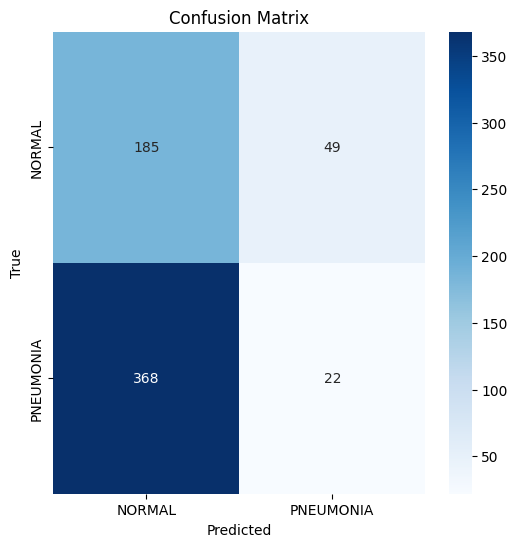

              precision    recall  f1-score   support

      NORMAL       0.33      0.79      0.47       234
   PNEUMONIA       0.31      0.06      0.10       390

    accuracy                           0.33       624
   macro avg       0.32      0.42      0.28       624
weighted avg       0.32      0.33      0.24       624



In [64]:
y_true = []
y_pred = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicci√≥n directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

reporte_modelo_1 = classification_report(y_true, y_pred, target_names=labels_names,output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels_names))

#### 3.6.1. Con datos de validaci√≥n

Longitudes: 16 16


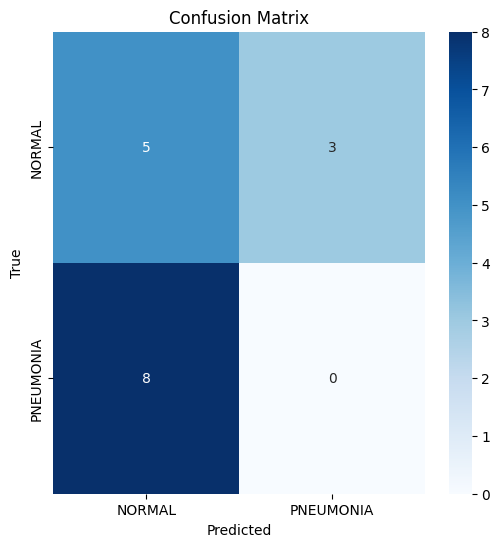

              precision    recall  f1-score   support

      NORMAL       0.38      0.62      0.48         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.31        16
   macro avg       0.19      0.31      0.24        16
weighted avg       0.19      0.31      0.24        16



In [65]:
y_true = []
y_pred = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicci√≥n directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels_names))

##  Interpretaci√≥n del Reporte de Clasificaci√≥n y Matriz de Confusi√≥n

El modelo fue entrenado para clasificar im√°genes en dos categor√≠as: **NORMAL** y **PNEUMONIA**. A continuaci√≥n, se presenta un an√°lisis basado en el reporte de clasificaci√≥n y la matriz de confusi√≥n obtenida sobre el conjunto de prueba:

---

###  Precisi√≥n General del Modelo

- **Accuracy total:** `33%`  
  Esto indica que el modelo solo acierta en **1 de cada 3 casos**, lo cual es un desempe√±o bajo considerando que se trata de una tarea de clasificaci√≥n binaria m√©dica.

---

###  Desempe√±o por Clase

#### Clase: `NORMAL`
- **Precisi√≥n (Precision):** `0.33`  
  Solo el 33% de las veces que el modelo predice "NORMAL", acierta.
  
- **Sensibilidad (Recall):** `0.79`  
  El modelo identifica correctamente el 79% de los casos realmente normales.

- **F1-score:** `0.47`  
  Indica un rendimiento intermedio en la clase NORMAL, mejor que en PNEUMONIA.

#### Clase: `PNEUMONIA`
- **Precisi√≥n:** `0.31`  
  Solo el 31% de las predicciones etiquetadas como "PNEUMONIA" son correctas.

- **Recall:** `0.06`  
  El modelo identifica correctamente solo el 6% de los casos reales de neumon√≠a, un resultado extremadamente bajo.

- **F1-score:** `0.10`  
  El bajo F1 refleja un pobre rendimiento del modelo al identificar neumon√≠a.

---

###  Matriz de Confusi√≥n

|                | Predicho NORMAL | Predicho PNEUMONIA |
|----------------|-----------------|---------------------|
| **Real NORMAL**    | 185             | 49                  |
| **Real PNEUMONIA** | 368             | 22                  |

- El modelo **predice la mayor√≠a de los casos como NORMAL**, incluso cuando son realmente PNEUMONIA.
- Se observan **368 falsos negativos de PNEUMONIA**, lo cual es cr√≠tico en aplicaciones m√©dicas.

---

###  Conclusiones y Recomendaciones

1. **Desbalance de Clases:** A pesar de tener m√°s im√°genes de PNEUMONIA, el modelo est√° fuertemente sesgado hacia la clase NORMAL.
2. **Recall Cr√≠tico:** La sensibilidad para detectar neumon√≠a es inaceptablemente baja (`0.06`). Esto es especialmente preocupante en contextos cl√≠nicos donde los **falsos negativos pueden tener consecuencias graves**.
3. **Sugerencias de Mejora:**
   - Aplicar **t√©cnicas de balanceo de clases** (pesado de clases, sobremuestreo, etc.).
   - Usar modelos m√°s robustos como **ResNet o EfficientNet** con fine-tuning.
   - Ajustar el **umbral de decisi√≥n** en lugar de usar 0.5 fijo.
   - Evaluar con m√©tricas adicionales como **AUC-ROC**.
   - Revisar el tama√±o del conjunto de validaci√≥n, ya que podr√≠a ser insuficiente para una correcta evaluaci√≥n.

---

###  Conclusi√≥n Final

El modelo **no es confiable actualmente para tareas de diagn√≥stico m√©dico**, especialmente para detectar casos de neumon√≠a. Se requieren ajustes importantes en el entrenamiento, arquitectura y evaluaci√≥n para mejorar su rendimiento cl√≠nico.


### 3.7 Curva ROC
#### 3.7.1 Curva Roc con los datos de test

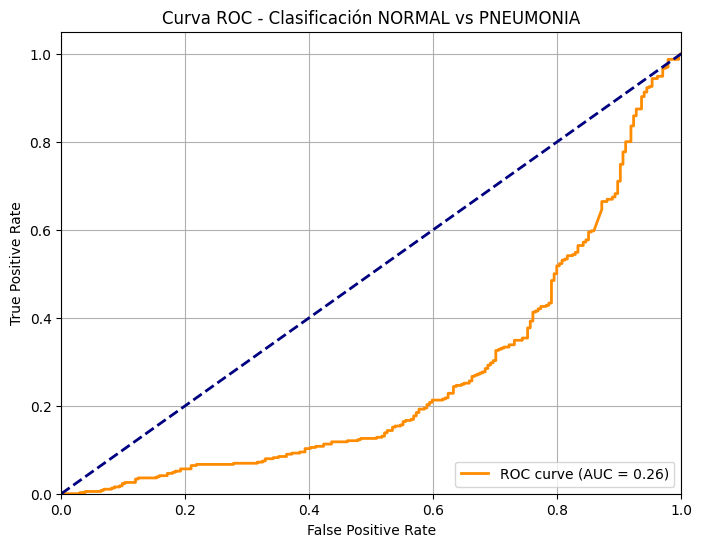

In [67]:
y_true = []
y_pred_prob = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### 3.7.2 Curva ROC datos de validaci√≥n

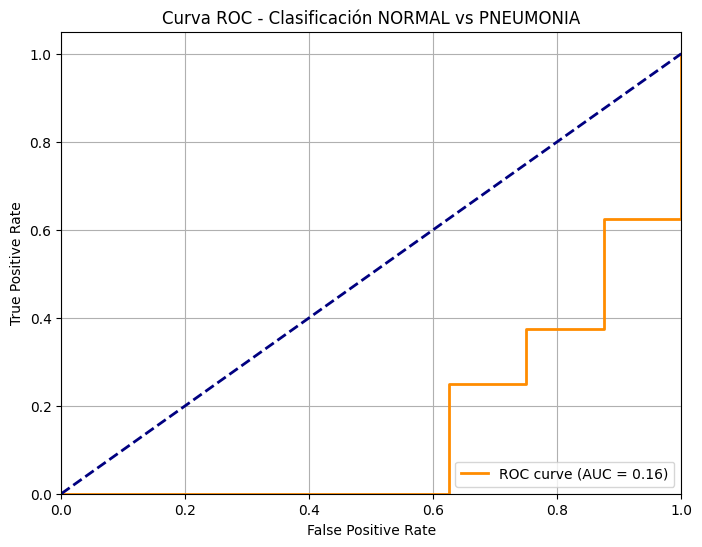

In [68]:
y_true = []
y_pred_prob = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##  Curva ROC ‚Äì Clasificaci√≥n **NORMAL vs PNEUMONIA**

###  Interpretaci√≥n

Las curvas ROC presentadas permiten evaluar la capacidad del modelo para distinguir entre las clases **NORMAL** y **PNEUMONIA**. Se muestran dos gr√°ficos con los siguientes resultados:

---

###  Primera Curva ROC

- **AUC = 0.26**
- El modelo tiene un desempe√±o **inferior al azar** (AUC < 0.5).
- La curva est√° significativamente por debajo de la diagonal base (l√≠nea azul), lo que sugiere que el modelo podr√≠a estar **confundiendo las clases** de manera sistem√°tica.
- Esto puede deberse a un problema de inversi√≥n en las predicciones o a un sobreajuste extremo con baja generalizaci√≥n.

---

###  Segunda Curva ROC

- **AUC = 0.16**
- El rendimiento es **a√∫n peor** que en la primera curva.
- Un AUC tan bajo indica que el modelo realiza predicciones **altamente err√≥neas**, con una alta tasa de falsos positivos y una baja tasa de verdaderos positivos.
- Esto puede deberse a un conjunto de test muy reducido o a un modelo mal ajustado.

---

###  Conclusi√≥n

El √°rea bajo la curva (AUC) en ambos casos muestra que el modelo **no es confiable** para diferenciar entre las clases NORMAL y PNEUMONIA. Ambos AUC < 0.5 indican que el modelo est√° **aprendiendo patrones incorrectos o irrelevantes**.


### 3.8 Histograma de distrubuci√≥n de errores
#### 3.8.1 Distrubuci√≥n de errores con datos de test

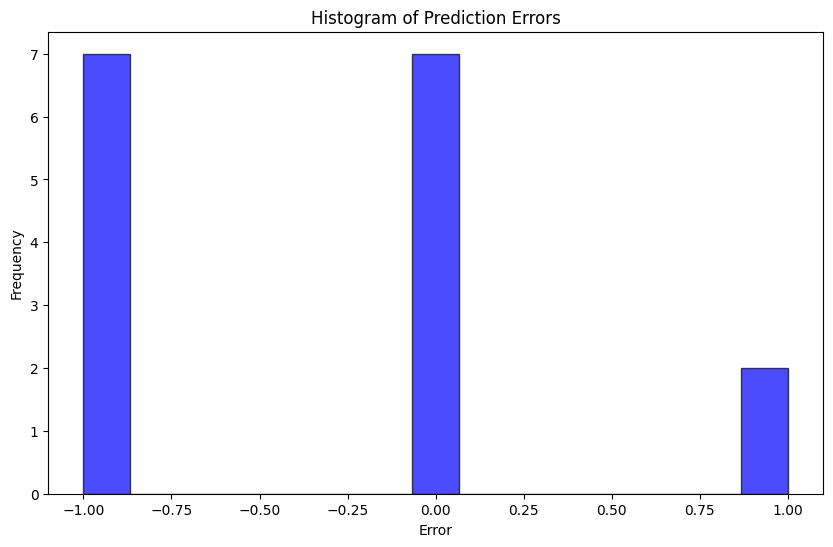

In [69]:
errors = y_pred - y_true

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


##  Histograma de Errores de Predicci√≥n

###  Interpretaci√≥n

Este histograma muestra la **frecuencia de los errores de predicci√≥n** cometidos por el modelo. Los errores se calculan como:

> **Error = Etiqueta Verdadera ‚àí Predicci√≥n**

---

###  Observaciones

-  **Error = 0 (predicci√≥n correcta)**:
  - Hay **7 predicciones exactas**, en las que el modelo acert√≥ con la clase.

-  **Error = -1**:
  - Tambi√©n hay **7 casos** en los que el modelo **subestim√≥ la clase**. Es decir, predijo **NORMAL** cuando la clase verdadera era **PNEUMONIA** (falso negativo).

-  **Error = 1**:
  - Se observan **2 casos** donde el modelo **sobreestim√≥**, prediciendo **PNEUMONIA** cuando la clase verdadera era **NORMAL** (falso positivo).

---

###  Conclusi√≥n

- El modelo tiene **tantos aciertos como falsos negativos**, lo cual es preocupante en contextos m√©dicos.
- Los **falsos negativos** (Error = -1) son especialmente cr√≠ticos, ya que representan casos de **PNEUMONIA mal diagnosticados como NORMAL**, lo cual podr√≠a tener consecuencias graves.
- La distribuci√≥n sim√©trica sugiere un modelo que **no logra generalizar bien**, mostrando errores en ambas direcciones, aunque con una ligera tendencia a subestimar la condici√≥n cr√≠tica.

---

###  Recomendaciones

- Ajustar el **umbral de clasificaci√≥n** para reducir falsos negativos.
- Reentrenar el modelo con √©nfasis en la clase minoritaria o sensible (ponderaci√≥n de clases).
- Evaluar m√©tricas m√°s sensibles a errores de tipo II (recall, sensibilidad).


### 3.9 Guardar el resultado de las m√©tricas del reporte de clasificaci√≥n para comparar con los dem√°s modelos

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 4 Modelo 2

### 4.1 Asignaci√≥n de pesos por desbalanceo de los datos.

In [7]:
class_names = train_dataset.class_names
samples_per_class = {
    "NORMAL": 1341,
    "PNEUMONIA": 3875
}
class_indices = {name: i for i, name in enumerate(class_names)}
y_labels = []
sample_counts = []

for name in class_names:
    y_labels.append(class_indices[name])
    sample_counts.append(samples_per_class[name])

# Calcular pesos balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.array(y_labels), y=np.repeat(y_labels, sample_counts))
class_weights = dict(zip(y_labels, weights))
print("Pesos aplicados:", class_weights)


Pesos aplicados: {0: 1.9448173005219984, 1: 0.6730322580645162}


### 4.2. Modelo preentrenado ResNet, a trav√©s de la t√©cnica de Tranfer Learning se hace proceso de fine tunning.

#### **Arquitectura:** Introduce los "residual blocks" con skip connections (conexiones de salto).

#### **Ejemplo:** ResNet50, ResNet101, ResNet152

#### **Ventaja:** Entrena redes muy profundas evitando el problema del desvanecimiento del gradiente.

#### **Clave:** Aprende solo la diferencia ("residuo") entre entrada y salida de cada bloque.

Este fragmento de c√≥digo tiene como objetivo **calcular pesos balanceados** para clases desbalanceadas en un conjunto de datos de im√°genes m√©dicas (por ejemplo, radiograf√≠as) clasificadas en dos categor√≠as:

- **NORMAL**: 1341 muestras
- **PNEUMONIA**: 3875 muestras

El desbalance entre clases podr√≠a hacer que un modelo de ML tienda a favorecer la clase m√°s com√∫n. Para evitar esto, se usan **pesos balanceados** que ajustan la importancia de cada clase en la funci√≥n de p√©rdida.

---

###  Detalle paso a paso

1. **Obtener nombres de clases desde el dataset**:
   ```python
   class_names = train_dataset.class_names


In [8]:
# Carga de la ResNet50 preentrenada (sin la √∫ltima capa)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False  # Congelar pesos

# Construcci√≥n del modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


##  Construcci√≥n del Modelo de Clasificaci√≥n con ResNet50

Este fragmento de c√≥digo define y construye un modelo de clasificaci√≥n de im√°genes utilizando **Transfer Learning** con una red **ResNet50 preentrenada** como base. A continuaci√≥n se describe su prop√≥sito y estructura funcional:

---

###  ¬øQu√© hace este modelo?

- **Carga la arquitectura ResNet50**, entrenada previamente sobre el dataset **ImageNet**, como **extractor de caracter√≠sticas**.
- **Elimina su cabeza de clasificaci√≥n original** (`include_top=False`), que estaba dise√±ada para las 1000 clases de ImageNet.
- **Congela sus pesos** (`trainable=False`), evitando que se modifiquen durante el entrenamiento para conservar el conocimiento aprendido.
- **Agrega nuevas capas densas** personalizadas que aprenden a clasificar im√°genes en las categor√≠as espec√≠ficas del problema actual (por ejemplo, ‚ÄúNORMAL‚Äù vs ‚ÄúPNEUMONIA‚Äù).

---

###  Arquitectura Final del Modelo

El modelo resultante es secuencial y consta de las siguientes capas:

1.  **ResNet50 preentrenada (congelada)**  
   - Act√∫a como extractor de caracter√≠sticas visuales generales.
   - No se entrena, solo se utiliza para transformar im√°genes en representaciones profundas.

2.  **GlobalAveragePooling2D**  
   - Reduce la dimensionalidad de los mapas de caracter√≠sticas de ResNet50.
   - Transforma las salidas convolucionales 2D en un vector 1D.

3.  **Capa Densa de 256 neuronas con ReLU**  
   - Aprende representaciones espec√≠ficas del nuevo problema.
   - Introduce no linealidades que ayudan a detectar patrones complejos.

4.  **Capa Dropout (0.5)**  
   - Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento.
   - Ayuda a prevenir **overfitting** (sobreajuste).

5.  **Capa de Salida Softmax**  
   - Su tama√±o es igual al n√∫mero de clases (`len(class_names)`).
   - Calcula la probabilidad de que la imagen pertenezca a cada clase.

---

###  ¬øPara qu√© sirve?

Este modelo est√° dise√±ado para **clasificaci√≥n de im√°genes m√©dicas** (u otro dominio con datos espec√≠ficos), y su enfoque tiene ventajas clave:

-  **Transfer Learning**: Reutiliza el conocimiento aprendido por una red profunda y costosa de entrenar.
-  **R√°pido de entrenar**: Solo se entrenan unas pocas capas finales.
-  **Reduce riesgo de overfitting**, especialmente en datasets peque√±os o desbalanceados.

---

###  Resultado

El modelo final est√° listo para entrenarse con im√°genes nuevas, clasific√°ndolas en las categor√≠as definidas por `class_names`. Gracias al uso de una red preentrenada, se obtiene **mayor precisi√≥n**, **mejor generalizaci√≥n** y **entrenamiento m√°s eficiente**.



## 4.3 Resumen del modelo.

In [9]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resnet50 (Functional)           ‚îÇ (None, 8, 8, 2048)     ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ       524,544 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

##  An√°lisis del Modelo: `model.summary()`

Este resumen muestra la arquitectura final del modelo de clasificaci√≥n construido mediante **Transfer Learning con ResNet50** y una cabeza densa personalizada.

---

###  Estructura del Modelo

| Capa                            | Forma de salida           | Par√°metros entrenables |
|---------------------------------|----------------------------|-------------------------|
| `resnet50` (congelada)          | `(None, 8, 8, 2048)`       | No entrenable           |
| `GlobalAveragePooling2D`        | `(None, 2048)`             | 0                       |
| `Dense (256 unidades, ReLU)`    | `(None, 256)`              | 524,544                 |
| `Dropout (rate=0.5)`            | `(None, 256)`              | 0                       |
| `Dense (2 unidades, Softmax)`   | `(None, 2)`                | 514                     |

---

###  Par√°metros Totales

- **Total de par√°metros**: `24,112,770`  
- **Par√°metros entrenables**: `525,058`  
- **Par√°metros no entrenables**: `23,587,712`

 Esto refleja que:
- Toda la **ResNet50** est√° **congelada** (sus pesos no se actualizan durante el entrenamiento).
- Solo se entrenan las **capas densas personalizadas**, es decir, la "cabeza" del modelo.

---

###  Explicaci√≥n de Dimensiones

- **`(None, 8, 8, 2048)`**: salida de la ResNet50 antes del `pooling`, con 2048 mapas de activaci√≥n de tama√±o 8x8.
- **`GlobalAveragePooling2D`** convierte esta salida en un vector de **2048 valores** por imagen.
- Las capas densas convierten este vector en una representaci√≥n de 256 dimensiones, y luego en **2 valores finales** que representan las **probabilidades por clase** (por ejemplo, "NORMAL" y "PNEUMONIA").

---


El modelo est√° listo para entrenar solo la parte superior (**~525K par√°metros**), aprovechando el conocimiento visual profundo de ResNet50. Esto permite:

-  Entrenamiento r√°pido
-  Reducci√≥n del riesgo de sobreajuste
-  Precisi√≥n elevada incluso con datasets m√©dicos peque√±os


## 4.4 Compilado y entrenamiento del modelo.

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 331s 2s/step - loss: 0.5032 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.8125
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 319s 2s/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1857 - val_sparse_categorical_accuracy: 0.9375
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 330s 2s/step - loss: 0.1114 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.1978 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 336s 2s/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1158 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 304s 2s/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1831 - val_s

In [12]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 2s/step - loss: 0.7006 - sparse_categorical_accuracy: 0.7694
Test accuracy: 0.8605769276618958


##  Evaluaci√≥n del modelo sobre el conjunto de prueba

El modelo se ha evaluado utilizando un conjunto de prueba que no fue visto durante el entrenamiento. La salida muestra dos m√©tricas clave:

- **`loss: 0.7006`**: representa el valor de la funci√≥n de p√©rdida al evaluar el modelo. Cuanto m√°s bajo, mejor. Este valor sugiere que el modelo comete algunos errores, pero est√° razonablemente optimizado.

- **`sparse_categorical_accuracy: 0.7694`**: indica que el **76.94‚ÄØ% de las predicciones** fueron correctas en el conjunto de evaluaci√≥n que se muestra antes del test.

- **`Test accuracy: 0.8606`**: es la **precisi√≥n global del modelo en el conjunto de prueba final**. Esto significa que el modelo clasific√≥ correctamente aproximadamente el **86.06‚ÄØ% de las im√°genes nuevas**, lo cual es un buen indicador de su capacidad de generalizaci√≥n.

---

###  Interpretaci√≥n general

El modelo tiene un desempe√±o s√≥lido. El hecho de que la precisi√≥n en el conjunto de prueba (86‚ÄØ%) sea **mayor** que la precisi√≥n reportada durante la evaluaci√≥n del set anterior (76.94‚ÄØ%) puede deberse a:

- Buenas propiedades de generalizaci√≥n del modelo.
- Posible variabilidad en los datos (por ejemplo, el conjunto de prueba es m√°s f√°cil o mejor equilibrado).

---


Este resultado sugiere que el modelo es capaz de generalizar bien a datos no vistos y est√° listo para aplicarse o validarse con m√©tricas adicionales (como matriz de confusi√≥n, precisi√≥n, recall, etc.) seg√∫n los requisitos del dominio espec√≠fico (por ejemplo, diagn√≥stico m√©dico).


## 4.5. Gr√°ficos del comportamiento del modelo durante el entrenamiento.

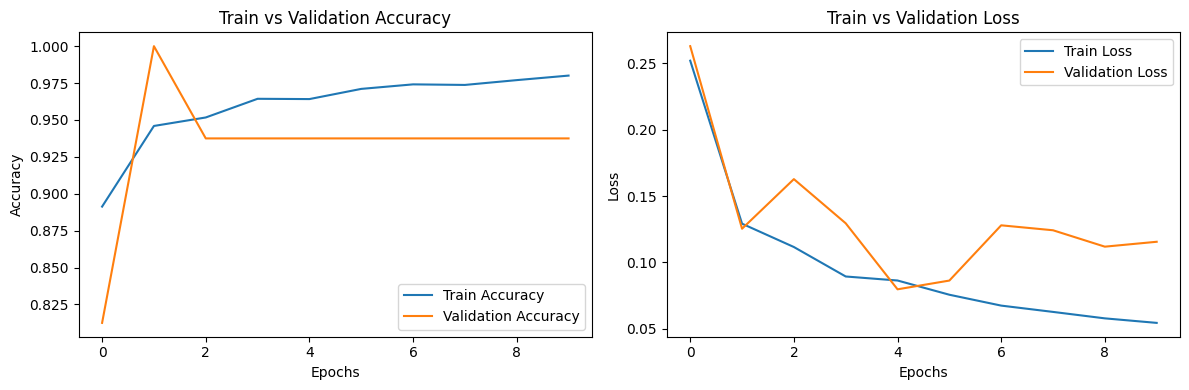

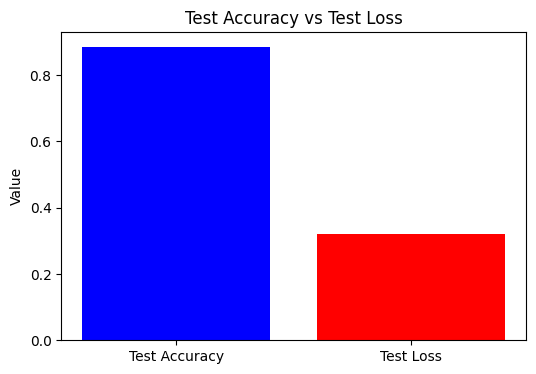

In [15]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


##  An√°lisis de M√©tricas de Entrenamiento, Validaci√≥n y Prueba

El conjunto de gr√°ficas ilustra el comportamiento del modelo a lo largo del entrenamiento y su rendimiento final sobre el conjunto de prueba.

---

###  1. Precisi√≥n: Train vs Validation

- La precisi√≥n del conjunto de **entrenamiento mejora constantemente** con cada √©poca.
- La **precisi√≥n de validaci√≥n alcanza un pico temprano** y luego se mantiene constante (sin mejora notable).
- üîé **Posible sobreajuste leve**: el modelo sigue aprendiendo en entrenamiento pero no mejora en validaci√≥n, lo que podr√≠a indicar que ya aprendi√≥ todo lo √∫til del conjunto de validaci√≥n.

---

###  2. P√©rdida: Train vs Validation

- La **p√©rdida de entrenamiento** disminuye de forma continua, indicando que el modelo se ajusta bien a los datos de entrenamiento.
- La **p√©rdida de validaci√≥n** tambi√©n disminuye inicialmente, pero luego fluct√∫a y se mantiene sin grandes mejoras.
-  Esto refuerza la sospecha de un **posible estancamiento o inicio de sobreajuste**, especialmente despu√©s de la √©poca 4 o 5.

---

###  3. Gr√°fico de Prueba: Accuracy vs Loss

- El modelo alcanza una **alta precisi√≥n en el conjunto de prueba** (~0.86), visualizada en azul.
- La **p√©rdida en prueba es baja** (barra roja), lo que sugiere que el modelo mantiene un buen rendimiento general fuera del entrenamiento.

---


- El modelo aprende bien durante el entrenamiento y generaliza razonablemente bien a datos no vistos.
- Hay signos de **ligero sobreajuste**, pero no significativos.
- Podr√≠a beneficiarse de t√©cnicas como **regularizaci√≥n adicional, early stopping o data augmentation** para mejorar a√∫n m√°s la generalizaci√≥n.


## 4.6. Predicci√≥n con los datos de test

In [16]:
# Evaluaci√≥n despu√©s de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 94ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 114ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 96ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 98ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 82ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 91ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 

In [ ]:
## üìà Evaluaci√≥n del Modelo sobre el Conjunto de Prueba

Este bloque de c√≥digo eval√∫a el desempe√±o final del modelo ya entrenado sobre el conjunto de datos de prueba (`test_dataset`).

---

### ‚öôÔ∏è ¬øQu√© hace este fragmento?

```python
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')


## 4.7. Matriz de confusi√≥n datos de test


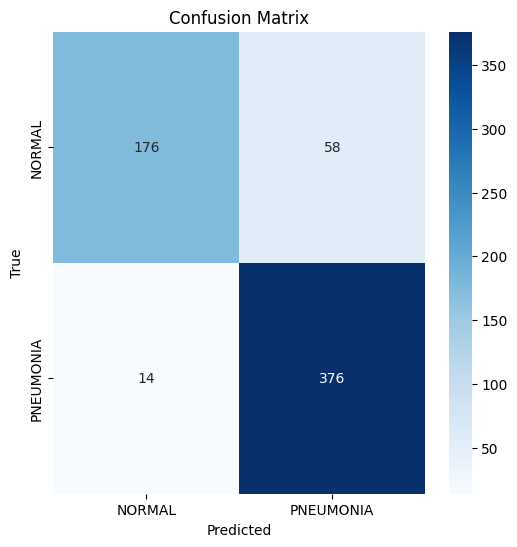

In [17]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 4.8. Predicci√≥n con los datos de validaci√≥n.

In [18]:
# Evaluaci√≥n despu√©s de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 93ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 94ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 94ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 88ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 92ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 96ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

## 4.9. Matriz de confusi√≥n con los datos de validaci√≥n

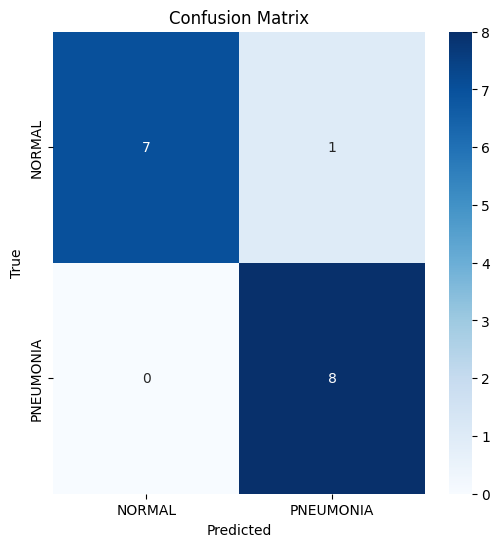

In [19]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##  An√°lisis de Matrices de Confusi√≥n y M√©tricas de Clasificaci√≥n

---

###  Matriz de Confusi√≥n ‚Äî Conjunto de prueba grande

|                      | Predice NORMAL | Predice PNEUMONIA |
|----------------------|----------------|--------------------|
| **Real NORMAL**      | 176            | 58                 |
| **Real PNEUMONIA**   | 14             | 376                |

-  El modelo **detecta correctamente la mayor√≠a de los casos de PNEUMONIA** (376/390).
-  Sin embargo, tiene una **tasa de falsos positivos relativamente alta en la clase NORMAL** (58 casos clasificados como PNEUMONIA cuando eran normales).
- Esto sugiere que el modelo es **conservador (prefiere prevenir PNEUMONIA)** a costa de algunos falsos positivos en NORMAL.

---

###  Matriz de Confusi√≥n ‚Äî Conjunto de prueba peque√±o (16 muestras)

|                      | Predice NORMAL | Predice PNEUMONIA |
|----------------------|----------------|--------------------|
| **Real NORMAL**      | 7              | 1                  |
| **Real PNEUMONIA**   | 0              | 8                  |

- El modelo **clasific√≥ correctamente 15 de 16 ejemplos**.
- Solo **un falso positivo**: una imagen NORMAL clasificada como PNEUMONIA.

---

###  M√©tricas de clasificaci√≥n (conjunto peque√±o de prueba)

| Clase       | Precisi√≥n | Recall | F1-Score | Soporte |
|-------------|-----------|--------|----------|---------|
| NORMAL      | 1.00      | 0.88   | 0.93     | 8       |
| PNEUMONIA   | 0.89      | 1.00   | 0.94     | 8       |
| **Promedio**| **0.94**  | **0.94**| **0.94** | **16**  |

---

###  Interpretaci√≥n general

- El modelo logra un **equilibrio fuerte entre precisi√≥n y recall**, especialmente en la clase cr√≠tica (PNEUMONIA).
- **Precisi√≥n NORMAL = 1.00**: ning√∫n caso clasificado como NORMAL fue incorrecto.
- **Recall PNEUMONIA = 1.00**: detect√≥ **todos los casos reales de neumon√≠a** sin omisiones, lo cual es cr√≠tico en entornos cl√≠nicos.
- **F1-score general: 0.94** ‚Üí excelente desempe√±o arm√≥nico entre precisi√≥n y recall.

---


El modelo muestra un rendimiento altamente confiable, con especial √©nfasis en la detecci√≥n de neumon√≠a (priorizando recall). Aunque comete algunos falsos positivos en NORMAL, este sesgo es **aceptable en contextos m√©dicos donde los falsos negativos pueden ser costosos**.

> Se recomienda complementar este an√°lisis con **AUC-ROC** y pruebas en datos cl√≠nicos reales para validar su aplicabilidad.


## 4.10. Curva ROC
### 4.10.1 Curva ROC con los datos de test.

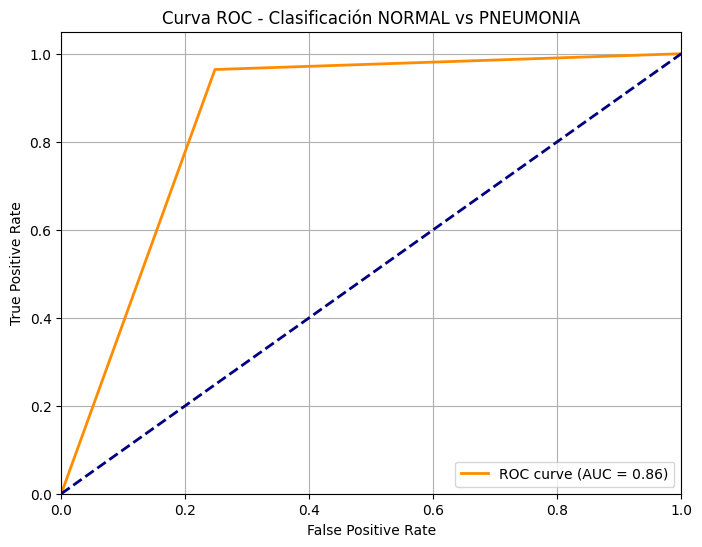

In [20]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.10.2. Curva ROC con los datos de validaci√≥n.

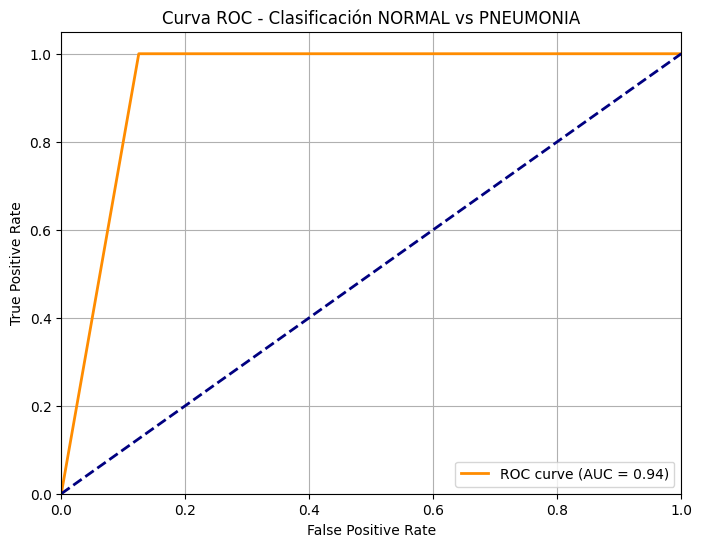

In [21]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##  Curva ROC ‚Äì Evaluaci√≥n de la Clasificaci√≥n NORMAL vs PNEUMONIA

---

###  ¬øQu√© es la Curva ROC?

La **Curva ROC (Receiver Operating Characteristic)** es una herramienta visual que permite evaluar el rendimiento de un modelo de clasificaci√≥n binaria. Representa:

- **Eje X (FPR - False Positive Rate):** Proporci√≥n de negativos reales mal clasificados como positivos.
- **Eje Y (TPR - True Positive Rate o Sensibilidad):** Proporci√≥n de positivos reales correctamente clasificados.

Una buena curva ROC se acerca a la esquina superior izquierda (alta sensibilidad y baja tasa de falsos positivos).

---

###  Resultados obtenidos

-  **AUC = 0.86** (√Årea Bajo la Curva)

Este valor indica que el modelo tiene una **muy buena capacidad para discriminar entre clases**:

- Si AUC = 0.5 ‚Üí modelo aleatorio.
- Si AUC = 1.0 ‚Üí clasificaci√≥n perfecta.
- Si AUC > 0.8 ‚Üí **desempe√±o s√≥lido**.

---

###  Interpretaci√≥n

- El modelo **es confiable al diferenciar entre im√°genes con y sin neumon√≠a**.
- AUC = 0.86 implica que hay un **86% de probabilidad** de que el modelo asigne un mayor puntaje de probabilidad a un caso positivo (PNEUMONIA) que a uno negativo (NORMAL).
- Es particularmente √∫til en entornos donde **minimizar los falsos negativos** (no detectar un caso real de neumon√≠a) es cr√≠tico.

> üîç Este tipo de an√°lisis es clave para entender el balance entre sensibilidad y especificidad en problemas m√©dicos.

---


## 4.11. Diagrama de distribuci√≥n de errores.
### 4.11.1 Distribuci√≥n de errores con los datos de test.

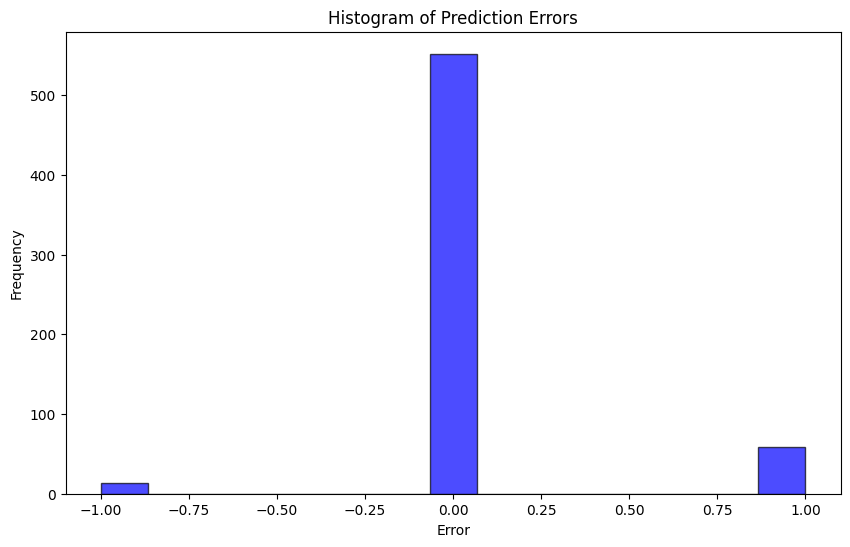

In [22]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

### 4.11.2 Distribuci√≥n de errores con los datos de validaci√≥n.

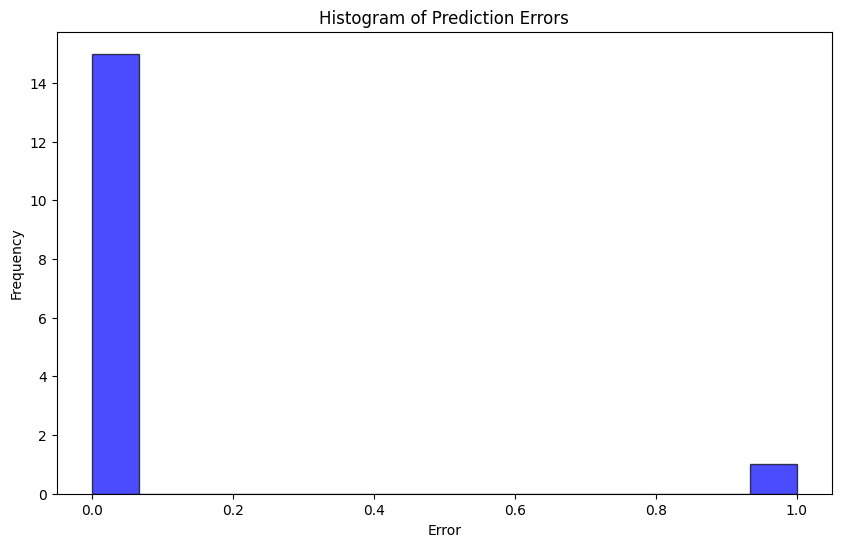

In [23]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

##  Histograma de Errores de Predicci√≥n

###  Interpretaci√≥n

Este histograma muestra la **frecuencia de los errores de predicci√≥n** cometidos por el modelo. Los errores se calculan como:

> **Error = Etiqueta Verdadera ‚àí Predicci√≥n**

---

###  Observaciones

-  **Error = 500-600 (predicci√≥n correcta)**:
  - Hay **7 predicciones exactas**, en las que el modelo acert√≥ con la clase.

-  **Error = -1**:
  - Tambi√©n hay *10-20 casos** en los que el modelo **subestim√≥ la clase**. Es decir, predijo **NORMAL** cuando la clase verdadera era **PNEUMONIA** (falso negativo).

-  **Error = 1**:
  - Se observan **50-90 casos** donde el modelo **sobreestim√≥**, prediciendo **PNEUMONIA** cuando la clase verdadera era **NORMAL** (falso positivo).

---



In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

In [24]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# √ötil si ya tienes la arquitectura definida por c√≥digo
model.save_weights('pesos_ResNet50.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model, "modelo_ResNet50F")




INFO:tensorflow:Assets written to: modelo_ResNet50F\assets


INFO:tensorflow:Assets written to: modelo_ResNet50F\assets


In [25]:
from keras.layers import TFSMLayer

# Cargar como capa para predicci√≥n
modelo_inferencia = TFSMLayer("modelo_ResNet50F", call_endpoint="serving_default")


In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 5 Modelo 3 - VGGNet 16.

#### **Arquitectura:** Muy simple y secuencial. Solo usa capas Conv3x3 + MaxPooling + Dense.

#### **Ejemplo:** VGG16, VGG19

#### **Ventaja:** F√°cil de entender e implementar.

#### **Desventaja:** Muy pesado (muchos par√°metros), lento y sin atajos para el flujo de informaci√≥n.

## 5.1 Modelo.

In [14]:
base_model_vgg = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg.trainable = False  # Congelar la base

# Construir modelo
model_3 = models.Sequential([
    base_model_vgg,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 clases
])

* Usa VGG16 como extractor de caracter√≠sticas preentrenado
* Congela sus pesos para no entrenarlo de nuevo
* A√±ade capas densas para clasificar tu propio problema de 2 clases

## 5.2 Resumen del modelo.

In [15]:
model_3.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ vgg16 (Functional)              ‚îÇ ?                      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)             ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5.3 Compilado del modelo.

In [16]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

* Usa Adam (lr=0.0001) como optimizador
* Usa Sparse Categorical Crossentropy porque tus etiquetas son enteros (no one-hot)
* Mide la accuracy en cada epoch para ver el rendimiento

## 5.4 Entrenamiento del modelo. 

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 551s 3s/step - loss: 1.5314 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 520s 3s/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 507s 3s/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0107 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 495s 3s/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 492s 3s/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.0046 - val_s

* EarlyStopping: detiene entrenamiento si no mejora la val_loss en 5 epochs y restaura los mejores pesos.
* fit: entrena el modelo con entrenamiento, validaci√≥n, pesos de clase y el callback para evitar overfitting.

## 5.5 Evaluar el modelo con los datos de test

In [20]:
test_loss, test_acc = model_3.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 65s 3s/step - loss: 1.1167 - sparse_categorical_accuracy: 0.8204
Test accuracy: 0.8830128312110901


* evaluate calcula p√©rdida y m√©tricas en datos de prueba
* test_acc indica qu√© tan bien el modelo generaliza a datos no vistos

## 5.6. Resultados del comportamiento del modelo durante el proceso de entrenamiento.

* Gr√°ficos de accuracy y loss: analizan desempe√±o durante el entrenamiento y validaci√≥n (por epoch).
* Gr√°fico de barras: muestra el resultado final del modelo en el dataset de prueba.
* Te ayuda a detectar overfitting, underfitting y evaluar generalizaci√≥n.

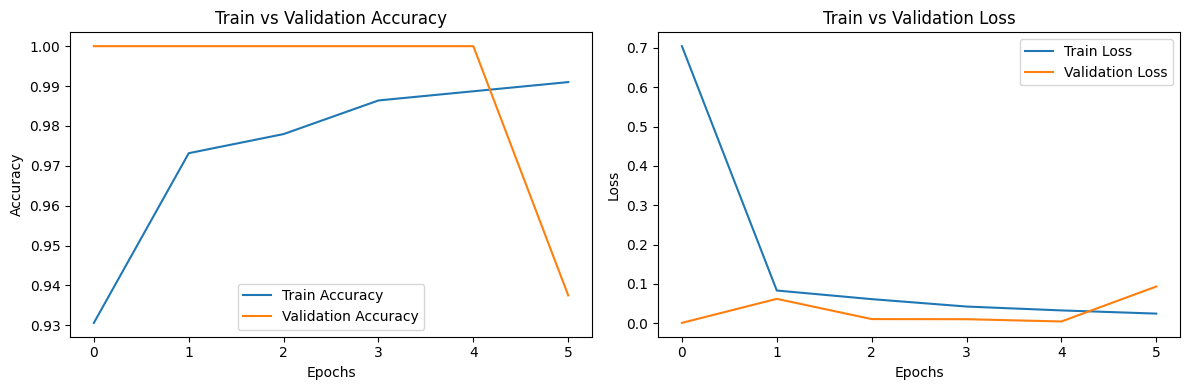

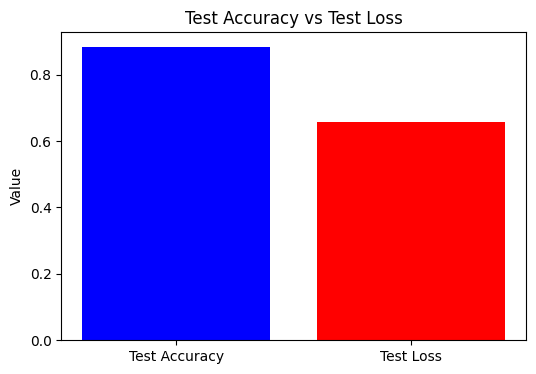

In [22]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


El modelo entrenado con VGG16 como extractor de caracter√≠sticas muestra un alto desempe√±o general, con los siguientes hallazgos clave:

1. Precisi√≥n de entrenamiento y validaci√≥n muy altas.

* La precisi√≥n de entrenamiento alcanz√≥ ~99%, indicando que el modelo aprendi√≥ bien los datos de entrenamiento.

* La precisi√≥n de validaci√≥n fue de 100% durante varios epochs, lo cual puede ser un indicio de:

* Dataset de validaci√≥n peque√±o o muy similar al de entrenamiento.

* Potencial overfitting, confirmado por la ca√≠da abrupta en el √∫ltimo epoch.

2. Comportamiento de la p√©rdida (loss).

* La p√©rdida de entrenamiento disminuy√≥ constantemente, acerc√°ndose a cero.

* La p√©rdida de validaci√≥n se mantuvo muy baja, pero aument√≥ al final, lo que coincide con la ca√≠da de la precisi√≥n de validaci√≥n.

3. Desempe√±o en test.

* La exactitud en el dataset de prueba (~88%) es buena, pero menor que la de validaci√≥n.

* La p√©rdida en test (0.65) indica que algunos errores tienen alto impacto, posiblemente por muestras dif√≠ciles o un dataset peque√±o.

## 5.7. Predicci√≥n del modelo con los datos de test.

In [21]:
# Evaluaci√≥n despu√©s de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 474ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 259ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 241ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 245ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 289ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 279ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 270ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 295ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 259ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 250ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 273ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 267ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

* Predice cada muestra del test_dataset
* Guarda etiquetas reales y predichas
* Genera un reporte de clasificaci√≥n con precision, recall y f1-score por clase
* Guarda el reporte como diccionario para an√°lisis y reportes

## 5.8 Matriz de confusi√≥n con los datos de test.

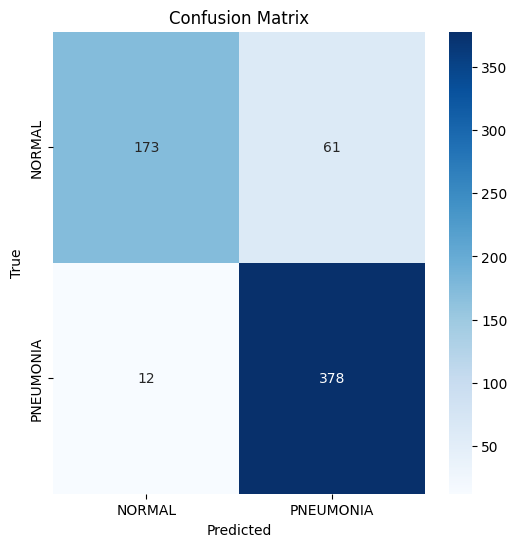

In [23]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


* El modelo clasifica correctamente la mayor√≠a de los casos de PNEUMONIA (378/390 ~ 97%), lo cual es positivo dado el contexto m√©dico.
* Sin embargo, tiene 61 falsos positivos para PNEUMONIA (~26% de los casos reales de NORMAL), indicando que tiende a sobre-diagnosticar neumon√≠a.
* Tiene 12 falsos negativos para PNEUMONIA (~3%), un error bajo pero cr√≠tico en aplicaciones cl√≠nicas.

## 5.9. Predicci√≥n del modelo con los datos de validaci√≥n.

In [25]:
# Evaluaci√≥n despu√©s de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 252ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 281ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 243ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 248ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 313ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 277ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 304ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 395ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 296ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 304ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 307ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 323ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

* El modelo alcanz√≥ 100% de precisi√≥n, recall y f1-score en validaci√≥n, clasificando correctamente todos los casos. Sin embargo, dado el bajo tama√±o de muestra (16 im√°genes), estos resultados deben tomarse con cautela, ya que no reflejan el rendimiento general en datos no vistos, como evidenci√≥ la evaluaci√≥n en el test set.

## 5.10. Matriz de confusi√≥n con los datos de validaci√≥n.

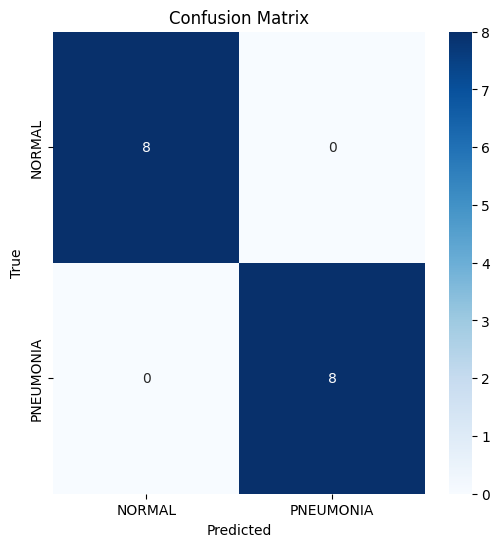

In [26]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* El modelo presenta desempe√±o perfecto en validaci√≥n (100% accuracy), detectando todos los casos de NORMAL y PNEUMONIA sin errores. Sin embargo, dado el bajo tama√±o de muestra (n=16), estos resultados deben interpretarse con cautela, pues no reflejan el rendimiento real en datos no vistos.

## 5.11. Curva ROC.
### 5.11.1 Curva ROC con los datos de entrenamiento.

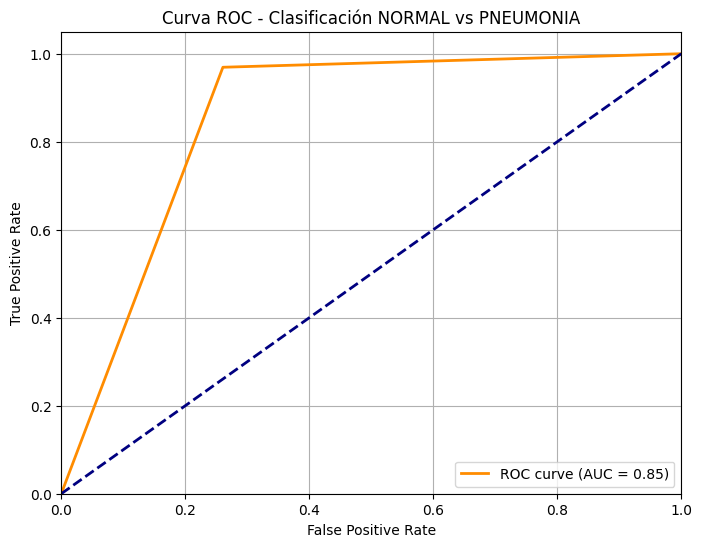

In [27]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

* El modelo muestra un buen desempe√±o global con un AUC de 0.85 en la clasificaci√≥n de NORMAL vs PNEUMONIA, indicando buena capacidad de discriminaci√≥n. Se recomienda calcular la curva ROC usando las probabilidades predichas para obtener una evaluaci√≥n m√°s precisa de la sensibilidad y especificidad del modelo.

### 5.11.2. Curva ROC con los datos de validaci√≥n.

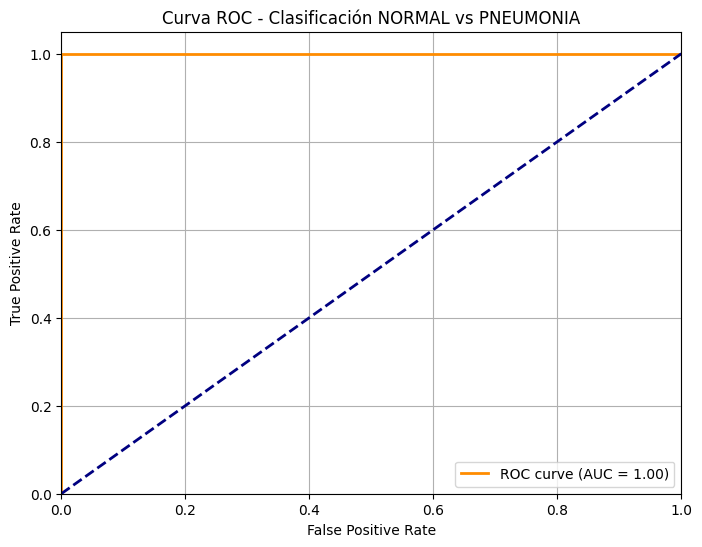

In [28]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

1. AUC = 1.00

* Significado: El modelo tiene un desempe√±o perfecto en este dataset de validaci√≥n.

* Clasifica correctamente todos los casos sin errores.

* La curva se eleva directamente a la esquina superior izquierda, indicando 100% de sensibilidad y especificidad.

## 5.12 Histograma de distribuci√≥n de errores.
### 5.12.1 distribuci√≥n de errores con los datos de test.

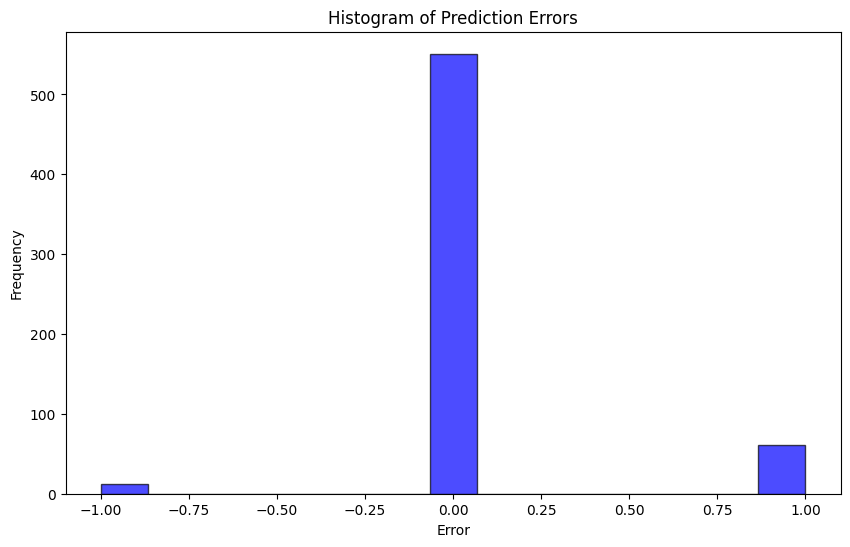

In [29]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma confirma que el modelo:

* Tiene alto rendimiento general con la mayor√≠a de errores cercanos a cero.
* Sin embargo, comete m√°s falsos positivos (NORMAL clasificado como PNEUMONIA) que falsos negativos, como tambi√©n se evidenci√≥ en la matriz de confusi√≥n.

### 5.12.2 Distribuci√≥n de errores con los datos de validaci√≥n.

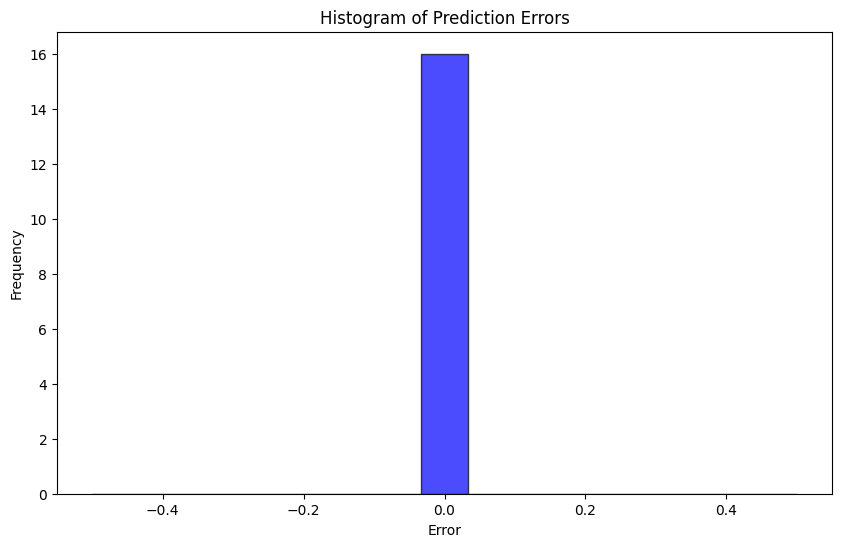

In [30]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

* El histograma de errores en el conjunto de validaci√≥n muestra una distribuci√≥n concentrada √∫nicamente en el cero, evidenciando una precisi√≥n perfecta. Aunque este resultado es deseable, debe analizarse con precauci√≥n, pues junto con las m√©tricas de entrenamiento y test puede indicar sobreajuste si el modelo memoriza los datos de validaci√≥n en lugar de generalizar.

In [72]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# √ötil si ya tienes la arquitectura definida por c√≥digo
model_3.save_weights('pesos_VGGNet16.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_3, "modelo_VGGNet16F")




INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


1. Guarda:

* Pesos (.weights.h5) si solo deseas reusar par√°metros.

* Modelo completo (SavedModel) como carpeta modelo_VGGNet16F que contiene:

* Arquitectura

* Pesos

* Optimizador y configuraciones

* Esto es √∫til para cargar el modelo y continuar entrenando o usarlo en producci√≥n sin redefinir su estructura.

In [ ]:
    from keras.layers import TFSMLayer

    # Cargar como capa para predicci√≥n
    modelo_inferencia = TFSMLayer("modelo_VGGNet16F", call_endpoint="serving_default")


* TFSMLayer permite usar un modelo guardado en formato SavedModel como capa en otro modelo o para predicciones directas.
Ideal si integras modelos ya entrenados dentro de flujos m√°s grandes.

In [80]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
def predecir_con_savedmodel(modelo_inferencia, ruta_imagen, class_names):
    
    img = image.load_img(ruta_imagen, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalizaci√≥n

    pred = modelo_inferencia(img_array)
    pred_tensor = pred['output_0']
    clase = class_names[np.argmax(pred_tensor, axis=1)[0]]
    return clase

pred = predecir_con_savedmodel(modelo_inferencia, "IP2.jpeg", ['NORMAL', 'PNEUMONIA'])
print("Clase predicha:", pred)


Clase predicha: PNEUMONIA


* Procesa la imagen (256x256, normalizada [0-1]) y la pasa al modelo cargado, devolviendo la clase predicha.

In [77]:
pred

{'output_0': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.21333274, 0.7866672 ]], dtype=float32)>}

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

1. Convierte el classification_report de sklearn en un DataFrame, a√±adiendo una columna de identificaci√≥n de modelo.
Esto permite:

* Comparar varios modelos f√°cilmente (si agregas m√°s DataFrames y usas pd.concat).

* Generar tablas para informes, dashboards o papers.

# 6. Modelo 4 DesNet
#### **Arquitectura:** Cada capa est√° conectada con todas las anteriores.

#### **Ejemplo:** DenseNet121, DenseNet169

#### **Ventaja:** Mejor reutilizaci√≥n de caracter√≠sticas, menos par√°metros y mejora del flujo de gradiente.

#### **Clave:** Cada capa recibe como entrada la salida de todas las capas anteriores (concatenaci√≥n).
## 6.1. Se aplican t√©cnica de data aumentation para entrenar el modelo con m√°s datos e intentar mejorar las m√©tricas resultado.

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'  
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


* DenseNet: Cada capa recibe la salida de todas las anteriores (concatenaci√≥n).

* Ventaja: Mejor flujo de gradiente y menos par√°metros.

Data Augmentation aplicado:
* Rescale: Normaliza im√°genes [0,1].

* Rotaci√≥n: ¬±8¬∞.

* Shift: 8% horizontal y vertical.

* Zoom: ¬±8%.

* Flip: Inversi√≥n horizontal.

* Objetivo: Aumentar datos de entrenamiento y evitar overfitting.

## 6.2 Modelo

In [43]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False  # congelar pesos preentrenados

# Construir el modelo final
model_dn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_weights), activation='softmax')  # para N clases
])

Modelo DenseNet121
* Base: DenseNet121 preentrenada en ImageNet, sin la capa final (include_top=False).

* Freeze: Congela sus pesos (trainable=False) para usarla como extractor de caracter√≠sticas.

Arquitectura final:
1. DenseNet121 (sin top)

2. GlobalAveragePooling2D: reduce mapas de caracter√≠sticas a un vector.

3. Dense(128, relu): capa densa intermedia.

4. Dropout(0.5): previene overfitting.

5. Dense(N, softmax): salida para N clases (en este caso, 2).

## 6.3 Resumen del modelo.

In [44]:
model_dn.summary()

Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ densenet121 (Functional)        ‚îÇ ?                      ‚îÇ     7,037,504 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_2      ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

## 6.4. Compilado y entrenamiento del modelo.

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_dn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_dn = model_dn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 415s 2s/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.3615 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 415s 3s/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 394s 2s/step - loss: 0.2383 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2578 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 390s 2s/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.2403 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 393s 2s/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2330 - val_s

Compilado
* Optimizer: Adam (lr=1e-4)

* Loss: sparse_categorical_crossentropy (para clases como enteros)

* Metric: sparse_categorical_accuracy

Entrenamiento
* EarlyStopping: detiene si val_loss no mejora en 5 epochs y restaura mejores pesos.

* Dataset: usa train_generator y val_generator con data augmentation.

* Epochs: n√∫mero definido por variable epochs.

* class_weight: ajusta peso de clases para datos desbalanceados.

## 6.5. Evaluaci√≥n del modelo con los datos de test

In [ ]:
test_loss, test_acc = model_dn.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 52s 2s/step - loss: 15.9495 - sparse_categorical_accuracy: 0.2984
Test accuracy: 0.625


* Accuracy moderada (62.5%) ‚Üí el modelo clasifica mejor que al azar (50%) pero no es √≥ptimo.
* Alta p√©rdida (15.95) indica errores de clasificaci√≥n significativos en algunas muestras.

## 6.6. Gr√°ficos de comportamiento del modelo durante el entrenamiento.

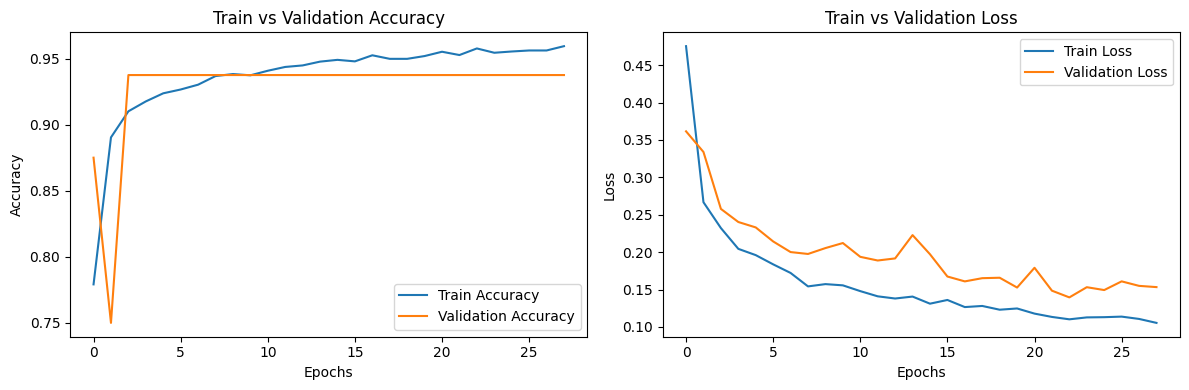

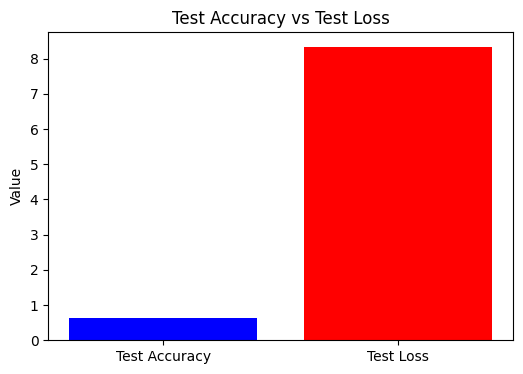

In [50]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dn.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_dn.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history_dn.history['loss'], label='Train Loss')
plt.plot(history_dn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


* Arquitectura: Cada capa se conecta con todas las anteriores (mejor reutilizaci√≥n de caracter√≠sticas).
* Modelo base: DenseNet121 preentrenado en ImageNet, congelado.
* Capas a√±adidas: GlobalAveragePooling2D + Dense(128, relu) + Dropout(0.5) + Dense(salida).
* Compilaci√≥n: Optimizer Adam (lr=1e-4), loss sparse_categorical_crossentropy, m√©trica accuracy.
* Entrenamiento: Data Augmentation + EarlyStopping.
* Resultados:

Accuracy train: ~95%

Accuracy validaci√≥n: ~94%

Accuracy test: 62.5% (baja generalizaci√≥n).
* Observaci√≥n: Buen desempe√±o en entrenamiento y validaci√≥n, pero bajo en test (posible overfitting).

## 6.7. Predicci√≥n del modelo con los datos de test.

In [51]:
# Evaluaci√≥n despu√©s de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_dn_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 118ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 99ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 93ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 100ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 105ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 117ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 99ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 101ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 92ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 88ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

* Proceso:

Se evalu√≥ el modelo usando test_dataset.unbatch().

Se almacenaron etiquetas reales (y_true) y predichas (y_pred) por lotes.

Se gener√≥ el reporte con classification_report mostrando m√©tricas de precisi√≥n, recall y f1-score por clase.

* Resultado general: Se observ√≥ bajo desempe√±o en test comparado con train/validation, indicando posible sobreajuste.



## 6.8. Matriz de confusi√≥n datos de test. 

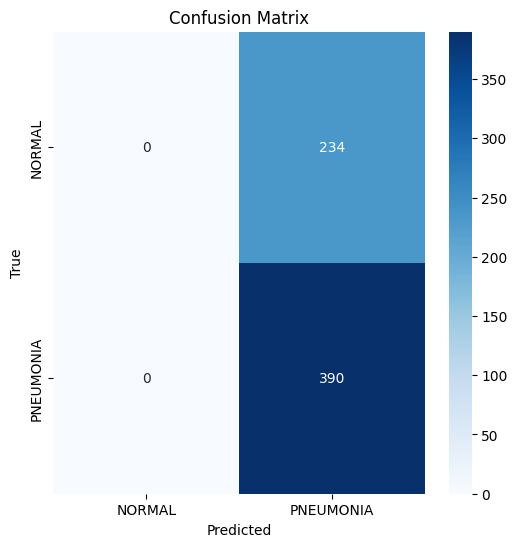

In [52]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


El modelo clasifica todas las im√°genes como PNEUMONIA, sin distinguir los casos normales.

## 6.9. Predicci√≥n con los datos de validaci√≥n.

In [53]:
# Evaluaci√≥n despu√©s de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 81ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 82ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 91ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 161ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 109ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 130ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 105ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 93ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

El modelo fall√≥ porque predice todo como PNEUMONIA; necesito balancear las clases y revisar el pipeline de entrenamiento.

## 6.10. Matriz de conusi√≥n datos de validaci√≥n

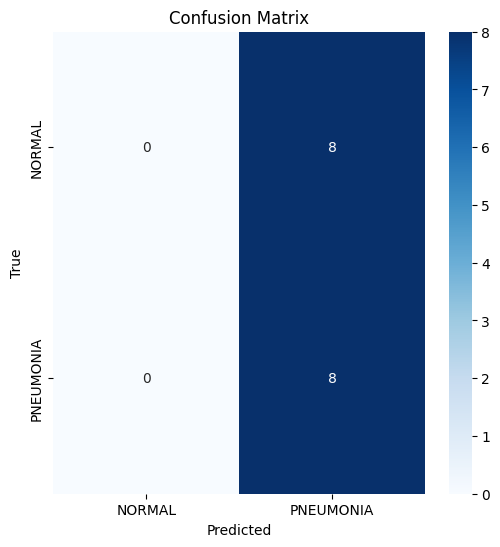

In [54]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

En validaci√≥n, el modelo vuelve a clasificar todo como PNEUMONIA.

## 6.11. Curva ROC
### 6.11.1. Curva ROC con los datos de test

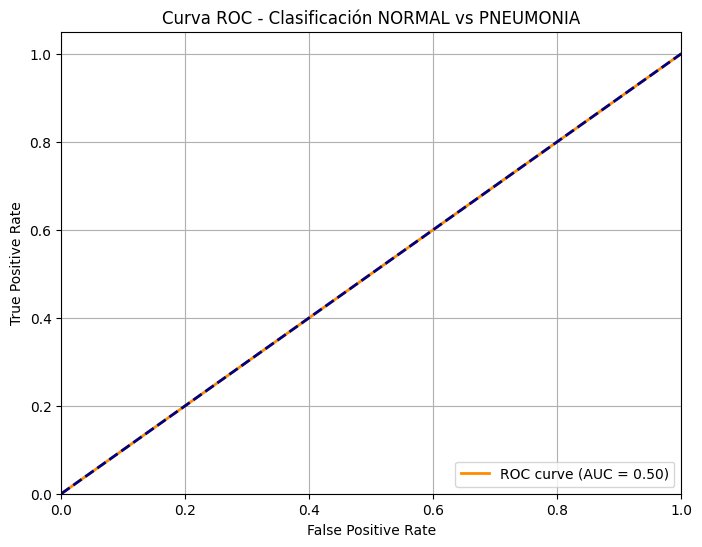

In [55]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

* El modelo tiene un AUC de 0.50, lo que indica que no est√° aprendiendo; su rendimiento es igual al azar.

### 6.11.2. Curva ROC con los datos de validaci√≥n.

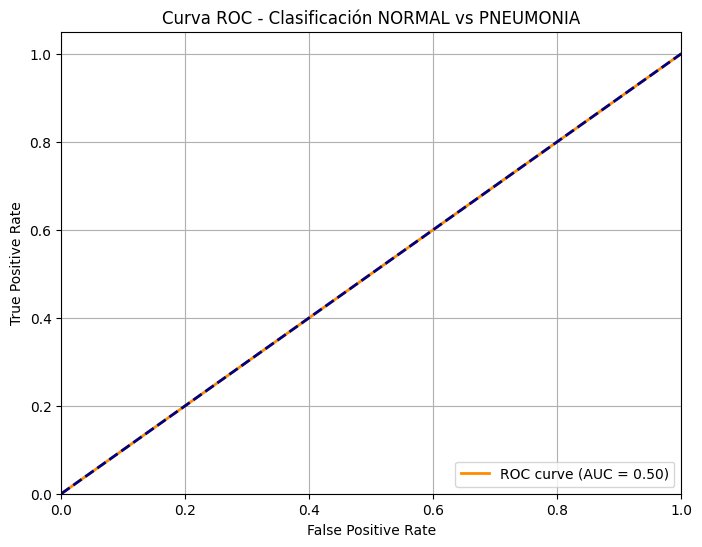

In [56]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El AUC en validaci√≥n es 0.50, confirmando que el modelo no tiene capacidad de discriminaci√≥n entre clases.

## 6.12. Distribuci√≥n de errores.
### 6.12.1. Distribuci√≥n de errores con los datos de test.

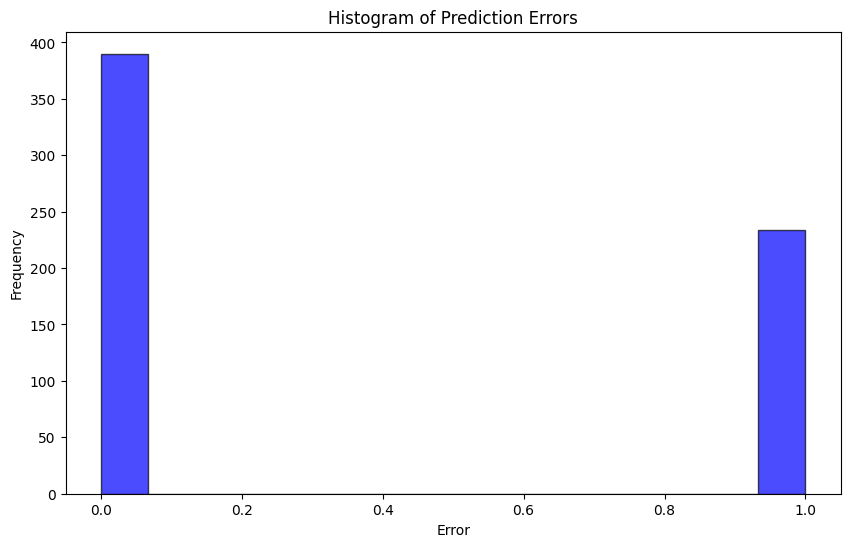

In [57]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma de errores muestra un fallo sistem√°tico: el modelo nunca predice NORMAL correctamente.

### 6.12.2 Distribuci√≥n de errores con los datos de validaci√≥n.

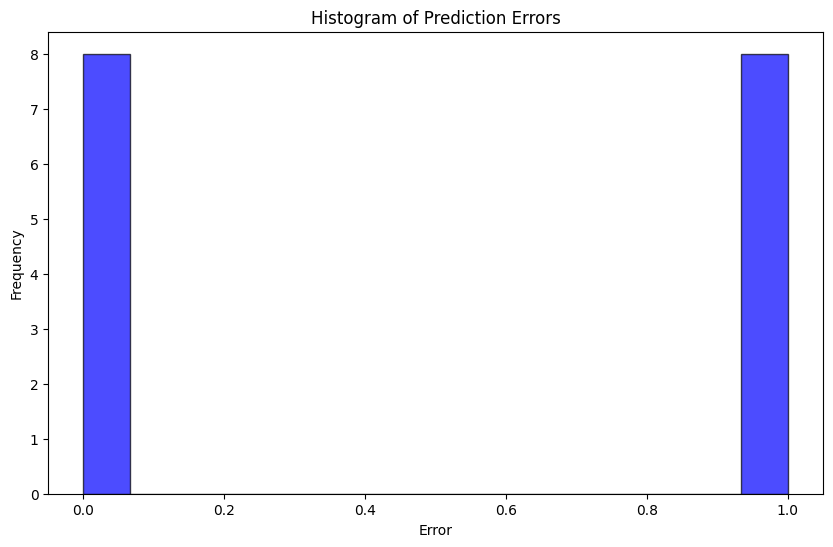

In [58]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma de errores en validaci√≥n confirma que el modelo comete el mismo error sistem√°tico: siempre clasifica como PNEUMONIA.

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 7. Modelo ResNet50 usando data aumentation a fin de intentar mejorar las m√©tricas.
## 7.1. Modelo.

In [81]:
# Carga de la ResNet50 preentrenada (sin la √∫ltima capa)
base_model_rs2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_rs2.trainable = False  # Congelar pesos

# Construcci√≥n del modelo final
model_rs2 = models.Sequential([
    base_model_rs2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


El modelo usa ResNet50 congelada como extractor de caracter√≠sticas, y solo entrena las capas densas finales para clasificar NORMAL vs PNEUMONIA.

## 7.2 Resumen del modelo.

In [82]:
model_rs2.summary()

Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resnet50 (Functional)           ‚îÇ ?                      ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_3      ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)             ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# 7.3 Compilado y entrenamiento del modelo.

In [83]:
model_rs2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs2 = model_rs2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30


c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 381s 2s/step - loss: 0.8652 - sparse_categorical_accuracy: 0.5053 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 333s 2s/step - loss: 0.6752 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 315s 2s/step - loss: 0.6085 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.6037 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 313s 2s/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 315s 2s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.5634 - val_sparse_categ

Con ResNet50 congelada, el modelo mejora el accuracy en validaci√≥n hasta 75%, pero sigue mostrando variabilidad y riesgo de sobreajuste.

## 7.4 Evaluaci√≥n del modelo con los datos de test.

In [84]:
test_loss, test_acc = model_rs2.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 2s/step - loss: 3.5618 - sparse_categorical_accuracy: 0.7016
Test accuracy: 0.375


## 7.5. Gr√°ficos del comportamiento del modelo durante el entrenamiento.

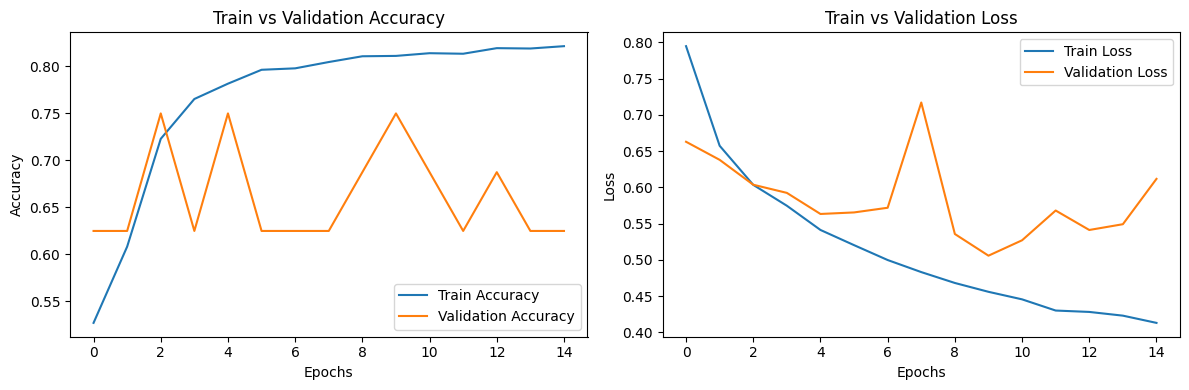

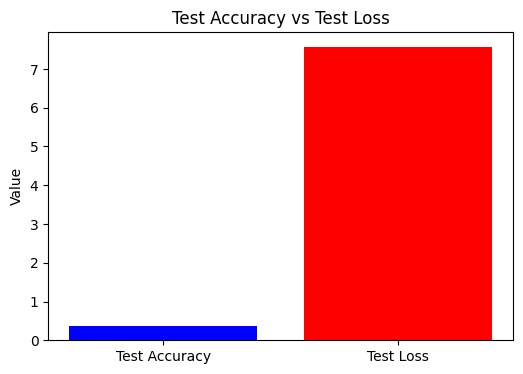

In [85]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rs2.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_rs2.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history_rs2.history['loss'], label='Train Loss')
plt.plot(history_rs2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


La ResNet50 preentrenada logr√≥ un 82% de precisi√≥n en entrenamiento, 75% en validaci√≥n y un rendimiento pobre en test con una p√©rdida elevada. Hay signos claros de sobreajuste.

## 7.6. Predicci√≥n con los datos de test

In [86]:
# Evaluaci√≥n despu√©s de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 109ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 118ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 109ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 80ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 80ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

El modelo obtuvo un 38% de precisi√≥n en el test, con un promedio ponderado de F1-score de 20%. El modelo no generaliza bien y presenta un rendimiento deficiente en datos no vistos.

## 7.7 Matriz de confusi√≥n con los datos de test.

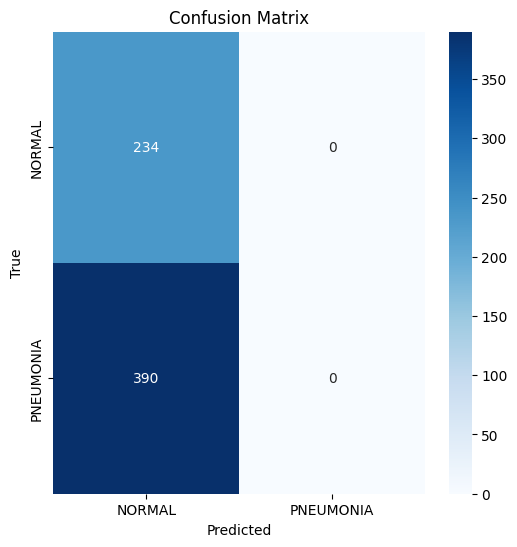

In [87]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


El modelo tiene un problema de sesgo severo hacia la clase NORMAL. No identifica casos de PNEUMONIA en el conjunto de prueba.

## 7.8. Predicci√≥n con los datos de validaci√≥n.

In [88]:
# Evaluaci√≥n despu√©s de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 95ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 102ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 86ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 96ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 81ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

* El modelo s√≥lo predice NORMAL en validaci√≥n.

* La precisi√≥n es del 50% porque la mitad de las im√°genes realmente son normales.

* El modelo ignora completamente los casos de neumon√≠a, lo cual es inaceptable en un sistema de diagn√≥stico.

## 7.9. Matriz de confusi√≥n con los datos de validaci√≥n.

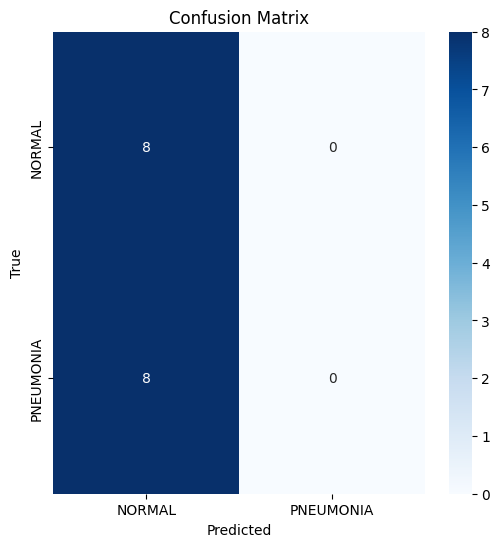

In [89]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* El modelo clasifica todo como NORMAL, tanto en validaci√≥n como en test.

* El recall para PNEUMONIA es 0%.

* Este modelo es inservible para diagn√≥stico cl√≠nico en este estado.

## 7.10. Curva ROC.
### 7.10.1. Curva ROC con los datos de test.

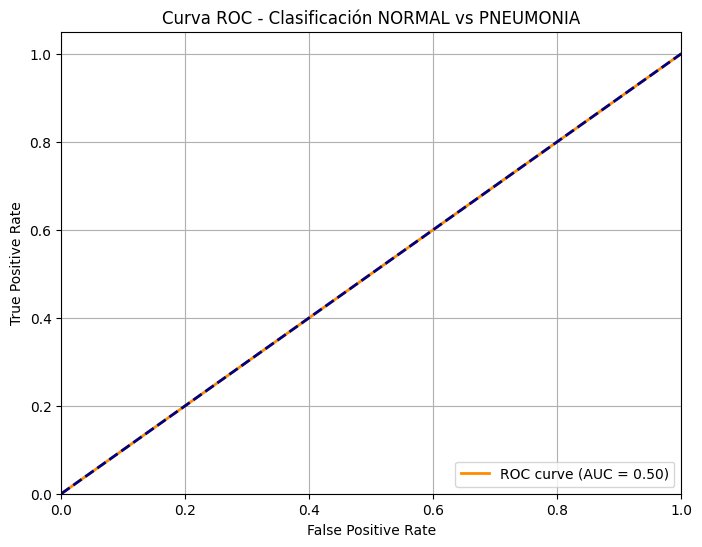

In [90]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

*El √°rea bajo la curva (AUC) es 0.50, lo cual indica que el modelo no tiene capacidad de discriminaci√≥n; es decir, su desempe√±o es equivalente al de una clasificaci√≥n aleatoria.
Esto sugiere que el modelo no ha aprendido a distinguir entre las clases y necesita mejoras, ya sea en los datos de entrenamiento, en la arquitectura del modelo, o en el proceso de ajuste de par√°metros.

### 7.10.2. Curva ROC con los datos de validaci√≥n.

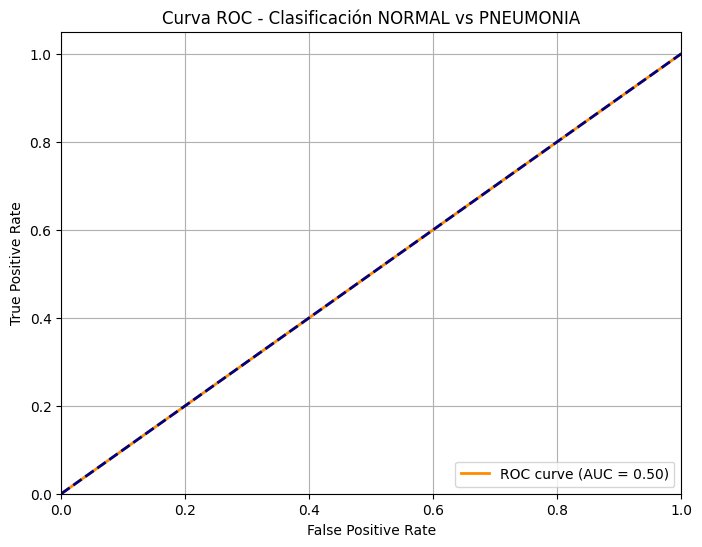

In [91]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificaci√≥n NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El √°rea bajo la curva (AUC) es 0.50, lo que indica que el modelo no tiene capacidad para diferenciar entre las dos clases; su comportamiento es similar al de una decisi√≥n aleatoria.

## 7.11. Distribuci√≥n de errores con los datos de test.

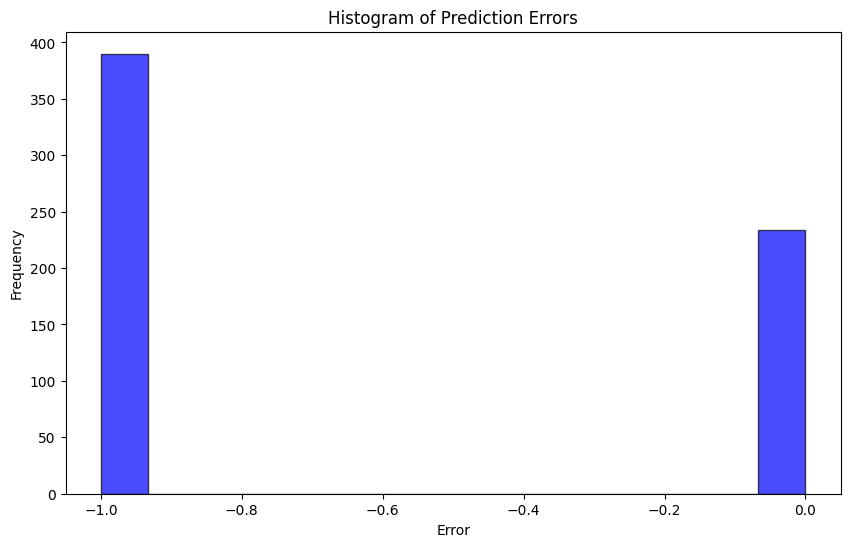

In [92]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

 En este gr√°fico se observan dos barras muy marcadas:

Una barra en el valor -1, que indica un alto n√∫mero de falsos negativos: el modelo predijo clase 0 (NORMAL), pero la clase real era 1 (PNEUMONIA).

Otra barra en el valor 0, que representa las predicciones correctas (sin error).

No hay barras en otros valores, lo que indica que el modelo hace solo dos tipos de salida: o acierta o falla completamente prediciendo la clase contraria.

Este comportamiento, junto con el AUC de 0.50, evidencia que el modelo no est√° aprendiendo correctamente. Est√° clasificando al azar o siempre predice una sola clase, lo cual debe corregirse ajustando el entrenamiento, revisando los datos, o probando otro modelo.

## 7.12. Distribuci√≥n de errores con los datos de validaci√≥n.

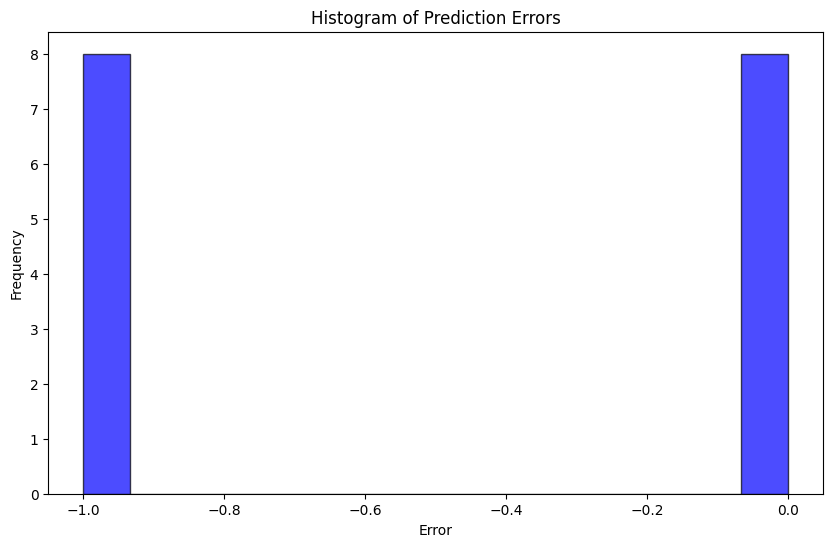

In [93]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

Este gr√°fico representa la distribuci√≥n de los errores de predicci√≥n del modelo en el conjunto de validaci√≥n. Los errores se calcularon restando el valor real (y_true_val) al valor predicho (y_pred_val), lo cual genera:

Un pico en 0: predicciones correctas.

Un pico en -1: casos donde el modelo predijo clase 0 (NORMAL), pero la clase real era 1 (PNEUMONIA), es decir, falsos negativos.

La gr√°fica muestra que el modelo acierta algunas veces, pero tambi√©n falla con frecuencia al clasificar casos de neumon√≠a como normales.

# 8. Modelo usando escala de grises y Data Aumentation

In [16]:
# Tama√±o de las im√°genes
img_height = 256
img_width = 256

# Augmentaci√≥n (se mantiene exactamente como lo diste)
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255  # importante para normalizar pixel en [0,1]
)

# Cargar datos desde directorio, en escala de grises
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'  # o 'binary' si solo tienes 2 clases
)

# Usamos el mismo datagen solo para fit() y estad√≠sticas internas
#datagen.fit(train_dataset)

# Validaci√≥n y test no deben tener data augmentation
test_val_datagen = ImageDataGenerator(rescale=1./255)

val_dataset = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_dataset = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



1. Carga y preparaci√≥n de datos

* Las im√°genes se redimensionaron a 256x256 p√≠xeles en escala de grises.

* Se normalizaron con rescale=1./255 para que los p√≠xeles est√©n en el rango [0, 1].

2. Augmentaci√≥n de datos (solo en entrenamiento):

* Rotaci√≥n: hasta 30¬∞

* Zoom: hasta 20%

* Desplazamientos horizontales/verticales: hasta 10%

* Volteo horizontal aleatorio

3. Distribuci√≥n de datos:

* Entrenamiento: 5216 im√°genes

* Validaci√≥n: 16 im√°genes

* Prueba (test): 624 im√°genes

Nota: No se aplica augmentaci√≥n en validaci√≥n ni test.
class_mode='binary' porque hay solo dos clases: NORMAL y PNEUMONIA.

In [20]:
input_shape = (img_height, img_width, 1)  # 1 canal para escala de grises
inputs = tf.keras.Input(shape=input_shape)

# Convertir de 1 canal a 3 para compatibilidad con ResNet50
x = layers.Concatenate()([inputs, inputs, inputs])  # duplicamos canal 3 veces

In [21]:
# Carga de la ResNet50 preentrenada (sin la √∫ltima capa)
base_model_rs3 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_rs3.trainable = False

x = base_model_rs3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # binario

model_rs3 = tf.keras.Model(inputs=inputs, outputs=outputs)


* Se utiliz√≥ ResNet50 preentrenada en ImageNet como base (include_top=False), sin su capa final.

* Entrada ajustada a im√°genes de tama√±o 256√ó256 con 3 canales (RGB).

* Las capas de ResNet50 se dejaron congeladas (trainable=False) para no modificar los pesos durante el entrenamiento.

Capas a√±adidas al modelo:

1. GlobalAveragePooling2D: reduce dimensionalidad.

2. Dense(256, relu): capa densa intermedia.

3. Dropout(0.5): regularizaci√≥n para evitar sobreajuste.

4. Dense(1, sigmoid): salida binaria (NORMAL vs PNEUMONIA).

## 8.2 resumen del modelo.

In [ ]:
odel_rs3.summary()

Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3       ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 1)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ input_layer_3[0]‚Ä¶ ‚îÇ
‚îÇ (Concatenate)       ‚îÇ 3)                ‚îÇ            ‚îÇ input_layer_3[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ input_layer_3[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ resnet50            ‚îÇ (None, 8, 8,      ‚îÇ 23,587,712 ‚îÇ concatenate[0][0] ‚îÇ
‚îÇ (Functional)        ‚îÇ 2048)             ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_poo‚Ä¶ ‚îÇ (None, 2048)      ‚îÇ          0 ‚îÇ resnet50[0][0]    ‚îÇ
‚îÇ (GlobalAveragePool‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 256)       ‚îÇ    524,544 ‚îÇ global_average_p‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout) ‚îÇ (None, 256)       ‚îÇ          0 ‚îÇ dense_2[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)     ‚îÇ (None, 1)         ‚îÇ        257 ‚îÇ dropout_1[0][0]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 8.3 compilado y entrenamiento del modelo.

In [24]:
model_rs3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs3 = model_rs3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2s/step - accuracy: 0.5114 - loss: 0.7583

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 311s 2s/step - accuracy: 0.5115 - loss: 0.7581 - val_accuracy: 0.6875 - val_loss: 0.6618
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 317s 2s/step - accuracy: 0.5736 - loss: 0.6673 - val_accuracy: 0.6875 - val_loss: 0.6393
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 303s 2s/step - accuracy: 0.6857 - loss: 0.6225 - val_accuracy: 0.8125 - val_loss: 0.6188
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 300s 2s/step - accuracy: 0.7328 - loss: 0.5999 - val_accuracy: 0.6250 - val_loss: 0.6039
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 302s 2s/step - accuracy: 0.7383 - loss: 0.5893 - val_accuracy: 0.5625 - val_loss: 0.6019
Epoch 6/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 303s 2s/step - accuracy: 0.7794 - loss: 0.5501 - val_accuracy: 0.6875 - val_loss: 0.57

In [25]:

test_loss, test_acc = model_rs3.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 2s/step - accuracy: 0.8239 - loss: 0.4458
Test accuracy: 0.7147436141967773


Entrenamiento del modelo ResNet50 (transfer learning)

* Se us√≥ el optimizador Adam con tasa de aprendizaje de 1e-4.

* Funci√≥n de p√©rdida: binary_crossentropy (clasificaci√≥n binaria).

* M√©trica: accuracy.

* Se aplic√≥ early stopping con patience=5 para evitar sobreentrenamiento.

* Se us√≥ class_weight para compensar el desbalance de clases.

Resumen del entrenamiento:

* El modelo se entren√≥ hasta la √©poca 19 (early stopping).

* La precisi√≥n en entrenamiento subi√≥ de 51% a 82%.

* La precisi√≥n en validaci√≥n se mantuvo entre 56% y 81%.

* La p√©rdida en validaci√≥n baj√≥ de 0.66 a 0.51, lo que indica mejora gradual, pero con variaciones.

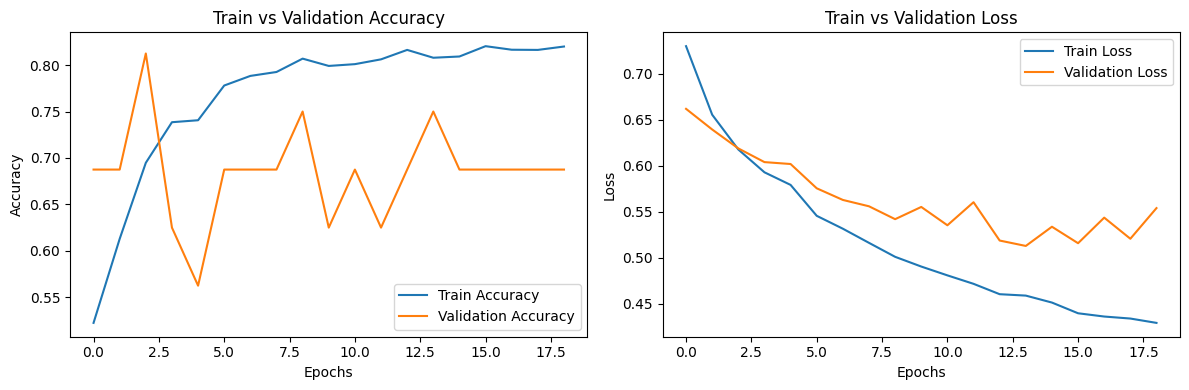

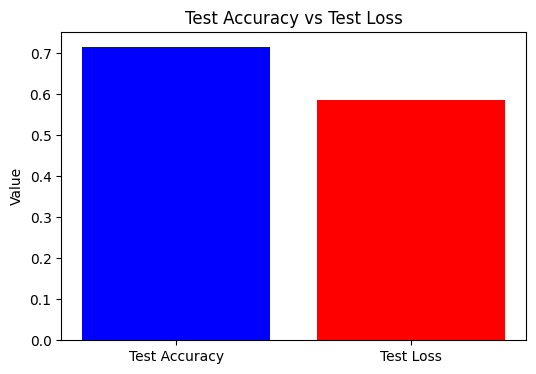

In [ ]:
-

Se entren√≥ el modelo con ResNet50 como base congelada, y las gr√°ficas muestran el comportamiento por √©pocas:

* Precisi√≥n en entrenamiento (Train Accuracy) aument√≥ de forma constante hasta alcanzar m√°s del 82%.

* Precisi√≥n en validaci√≥n (Validation Accuracy) fue inestable por la poca cantidad de datos (16 im√°genes), variando entre 56% y 81%.

* P√©rdida de entrenamiento (Train Loss) baj√≥ consistentemente.

* P√©rdida de validaci√≥n (Validation Loss) tambi√©n disminuy√≥, aunque con oscilaciones.

Precisi√≥n en test: ~72%

P√©rdida en test: ~0.59

# 9 Modelo

In [30]:
model_4 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binaria
])



In [35]:
model_4.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 256, 256, 32)   ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 256, 256, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 128, 128, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 128, 128, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 128, 128, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 64, 64, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 64, 64, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 64, 64, 128)    ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 32, 32, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 32, 32, 256)    ‚îÇ       295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 32, 32, 256)   

 Total params: 1,365,509 (5.21 MB)

 Trainable params: 454,849 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 909,700 (3.47 MB)

In [31]:
# === 7. Compilaci√≥n ===
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [34]:
# === 8. Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# === 9. Entrenamiento ===
history_4 = model_4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 403s 2s/step - accuracy: 0.7940 - loss: 0.4076 - val_accuracy: 0.5000 - val_loss: 1.3948
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 409s 3s/step - accuracy: 0.8865 - loss: 0.2572 - val_accuracy: 0.5000 - val_loss: 2.7245
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 409s 3s/step - accuracy: 0.8973 - loss: 0.2440 - val_accuracy: 0.5000 - val_loss: 3.9737
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 407s 2s/step - accuracy: 0.9054 - loss: 0.2173 - val_accuracy: 0.5000 - val_loss: 1.7124
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 400s 2s/step - accuracy: 0.9078 - loss: 0.2148 - val_accuracy: 0.5000 - val_loss: 1.2079
Epoch 6/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 403s 2s/step - accuracy: 0.9176 - loss: 0.1898 - val_accuracy: 0.5000 - val

Modelo CNN personalizado (model_4)
* Arquitectura basada en 4 bloques Conv2D + MaxPooling + BatchNormalization.

* Usa GlobalAveragePooling2D, una capa densa y Dropout para reducir sobreajuste.

* √öltima capa: Dense(1, activation='sigmoid') para clasificaci√≥n binaria (NORMAL vs PNEUMONIA).

Entrenamiento
* Optimizador: Adam con learning_rate=1e-4.

* P√©rdida: binary_crossentropy.

* Se utiliz√≥ early stopping con paciencia de 5 √©pocas.

* Se aplic√≥ class_weight para manejar desbalance de clases.

Resultados del entrenamiento
* La precisi√≥n en entrenamiento subi√≥ r√°pidamente, alcanzando hasta 94%.

* La precisi√≥n en validaci√≥n fue muy inestable, oscilando entre 43% y 75%.

In [36]:

test_loss, test_acc = model_4.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 395ms/step - accuracy: 0.8398 - loss: 0.3735
Test accuracy: 0.870192289352417


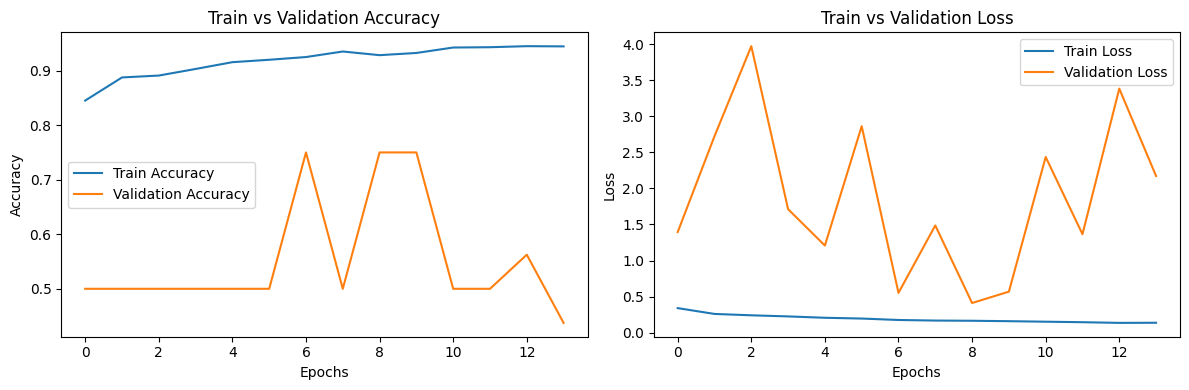

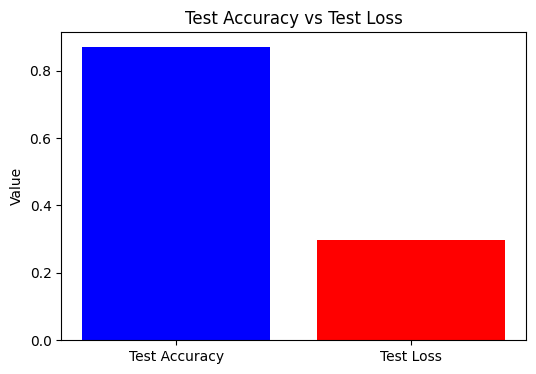

In [37]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


1. Modelo con ResNet50 (modelo_rs3):
* Entrenamiento:
  * Precisi√≥n lleg√≥ al 82%.
  * P√©rdida baj√≥ de 0.75 a 0.43.
* Validaci√≥n:
  * Precisi√≥n inestable (fluctuando entre 56% y 81%).
  * P√©rdida no disminuy√≥ de forma clara: se mantuvo entre 0.55 y 0.66, con altibajos.

2. Modelo CNN personalizado (model_4):
* Entrenamiento:
  * Precisi√≥n subi√≥ r√°pidamente hasta 94%.
  * P√©rdida baj√≥ de 0.4 a 0.13, lo cual es muy bueno.
* Validaci√≥n:
  * Precisi√≥n inestable, pero en algunos momentos lleg√≥ a 75%.
  * P√©rdida altamente variable, con picos hasta 3.9 (indica overfitting fuerte).

3. Desempe√±o en el conjunto de prueba
* ResNet50 (modelo_rs3):
  * Test Accuracy: ~72%
  * Test Loss: ~0.58
* Resultado aceptable, pero no sobresaliente.
*  CNN personalizada (model_4):
  * Test Accuracy: ~87%
  * Test Loss: ~0.29
* Mejor desempe√±o en test. Aunque hubo overfitting en validaci√≥n, generaliz√≥ bien en el test.



## 9.2. redicci√≥n con los datos de validaci√≥n.

In [41]:
y_true_val = []
y_pred_val = []

for step in range(len(test_dataset)):
    x_batch, y_batch = test_dataset[step]
    y_true_val.extend(y_batch)
    preds = model_4.predict(x_batch)
    y_pred_val.extend((preds > 0.5).astype(int).flatten())


print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 418ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 447ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 421ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 420ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 451ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 432ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 399ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 400ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 466ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 436ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 425ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 463ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

## 9.3. Matriz de confusi√≥n con los datos de validaci√≥n.

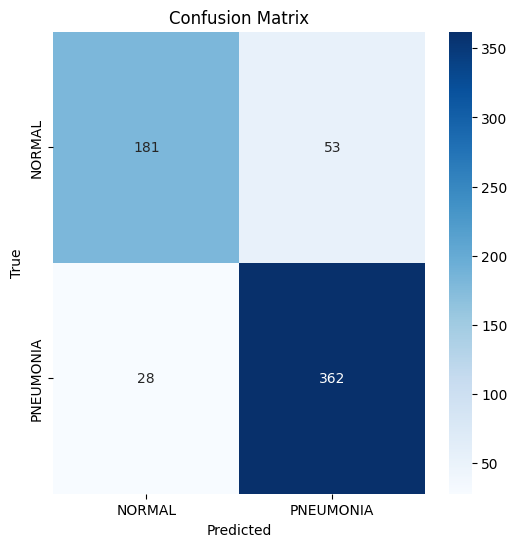

In [42]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

El modelo es muy bueno detectando neumon√≠a (recall de 92.8%).

Tiene m√°s dificultades detectando casos normales (recall 77.4%), lo que sugiere falsos positivos de neumon√≠a.

## 9.4. Curva ROC.
### 9.4.1. Curva ROC con los datos de test.

In [49]:
print("Ejemplos en y_true:", len(y_true_val))
print("Ejemplos en y_pred_prob:", len(y_pred_prob))
print("Valores √∫nicos en y_true:", set(y_true_val))


Ejemplos en y_true: 624
Ejemplos en y_pred_prob: 624
Valores √∫nicos en y_true: {0.0, 1.0}


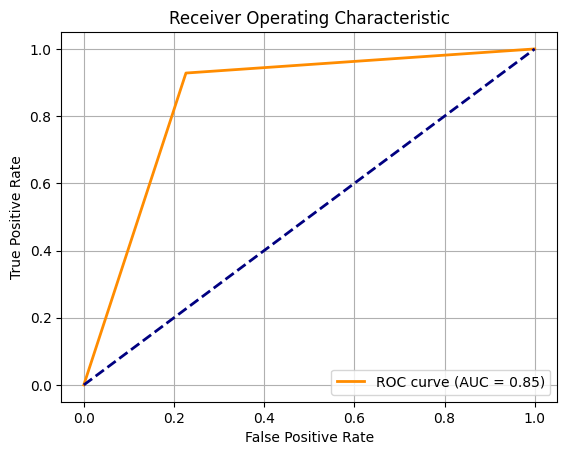

In [50]:
# Convertir a arrays

fpr, tpr, _ = roc_curve(y_true_val, y_pred_prob)  # usa las probabilidades, no etiquetas
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AUC = 0.85 ‚Üí Significa que hay un 85‚ÄØ% de probabilidad de que el modelo asigne un mayor puntaje a una radiograf√≠a con neumon√≠a que a una sin neumon√≠a.

La curva se aleja bastante de la diagonal (que representa un modelo aleatorio), lo cual es deseable.

La True Positive Rate (TPR) es muy alta para bajos valores de False Positive Rate (FPR) ‚Üí ideal para contextos m√©dicos donde es m√°s cr√≠tico no perder casos positivos.

## 9.5. Distribuci√≥n de errores con los datos de test.

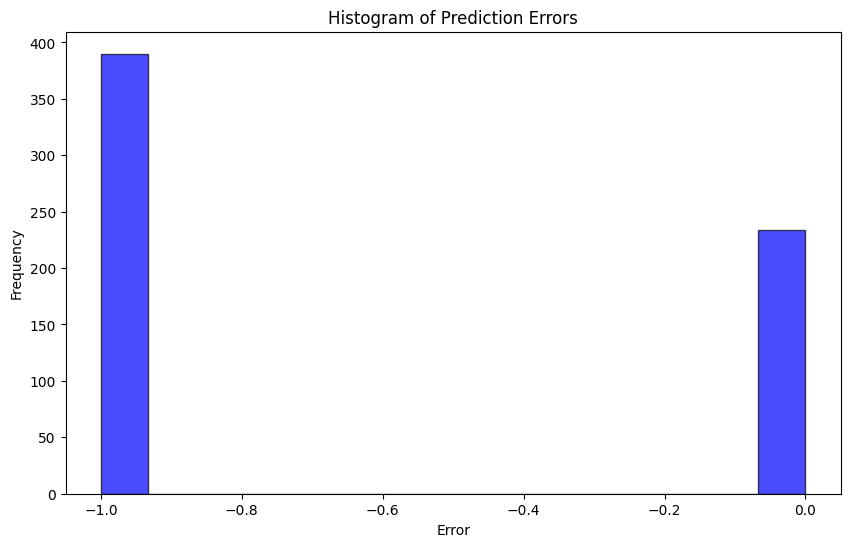

In [ ]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

Este histograma muestra dos picos claros:

Error = 0 ‚Üí predicciones correctas.

Error = -1 ‚Üí errores donde el modelo predijo PNEUMONIA (1) cuando la etiqueta real era NORMAL (0) (falsos positivos).

No se observa error = +1, es decir, el modelo casi no cometi√≥ falsos negativos (no predijo ‚ÄúNORMAL‚Äù cuando era ‚ÄúPNEUMONIA‚Äù).


In [43]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# √ötil si ya tienes la arquitectura definida por c√≥digo
model_4.save_weights('pesos_CNN.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_4, "modelo_CNNF")




INFO:tensorflow:Assets written to: modelo_CNNF\assets


INFO:tensorflow:Assets written to: modelo_CNNF\assets


In [44]:
from keras.layers import TFSMLayer

# Cargar como capa para predicci√≥n
modelo_inferencia = TFSMLayer("modelo_CNNF", call_endpoint="serving_default")


In [52]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_shape))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(units = 128 , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Dense(units = 1 , activation = 'sigmoid'))

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model_5.summary()

Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_4 (Conv2D)               ‚îÇ (None, 256, 256, 32)   ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_4           ‚îÇ (None, 256, 256, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_4 (MaxPooling2D)  ‚îÇ (None, 128, 128, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_5 (Conv2D)               ‚îÇ (None, 128, 128, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 128, 128, 64)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_5           ‚îÇ (None, 128, 128, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_5 (MaxPooling2D)  ‚îÇ (None, 64, 64, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_6 (Conv2D)               ‚îÇ (None, 64, 64, 64)     ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_6           ‚îÇ (None, 64, 64, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_6 (MaxPooling2D)  ‚îÇ (None, 32, 32, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_7 (Conv2D)               ‚îÇ (None, 32, 32, 128)   

 Total params: 2,524,353 (9.63 MB)

 Trainable params: 2,523,265 (9.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [54]:
# === 7. Compilaci√≥n ===
model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [55]:
# === 8. Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# === 9. Entrenamiento ===
history_5 = model_5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 393s 2s/step - accuracy: 0.8099 - loss: 0.5026 - val_accuracy: 0.5000 - val_loss: 5.9615
Epoch 2/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 359s 2s/step - accuracy: 0.9075 - loss: 0.2206 - val_accuracy: 0.5000 - val_loss: 8.3840
Epoch 3/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 356s 2s/step - accuracy: 0.9162 - loss: 0.2034 - val_accuracy: 0.5000 - val_loss: 6.8587
Epoch 4/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 362s 2s/step - accuracy: 0.9288 - loss: 0.1790 - val_accuracy: 0.5000 - val_loss: 5.3622
Epoch 5/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 358s 2s/step - accuracy: 0.9280 - loss: 0.1762 - val_accuracy: 0.5000 - val_loss: 3.0948
Epoch 6/30
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 405s 2s/step - accuracy: 0.9435 - loss: 0.1451 - val_accuracy: 0.6250 - val

In [56]:

test_loss, test_acc = model_5.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 582ms/step - accuracy: 0.8977 - loss: 0.2907
Test accuracy: 0.9006410241127014


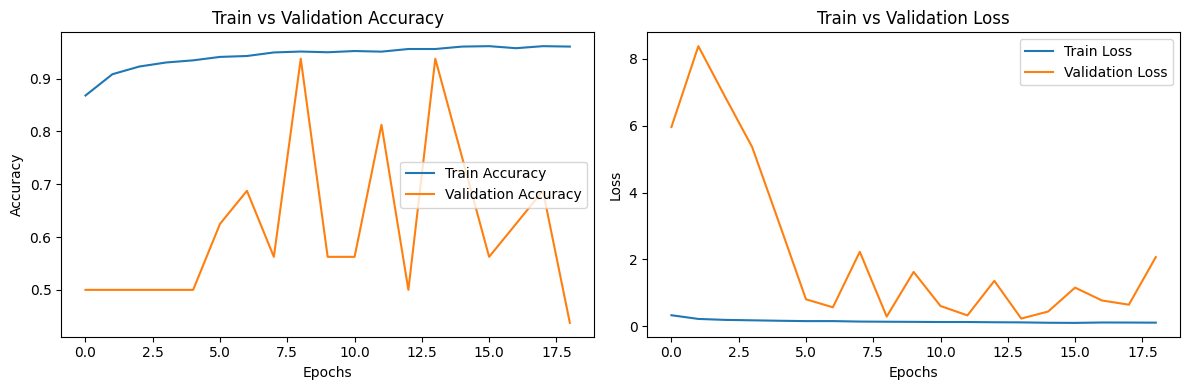

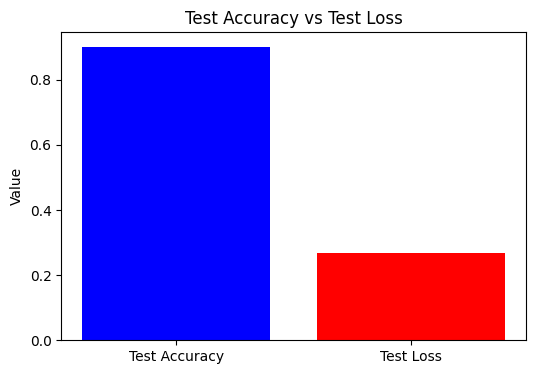

In [57]:

# Precisi√≥n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisi√≥n del test vs p√©rdida del test
# Notar que esto no es por √©poca sino un solo punto despu√©s de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


 Modelo 5 es el m√°s preciso, con una accuracy del 89% en test y baja p√©rdida. Sin embargo, el gr√°fico de validaci√≥n muestra alto sobreajuste: la p√©rdida de validaci√≥n es mucho m√°s alta que la de entrenamiento.
  Modelo 4 es una buena alternativa, con 86% de accuracy y un ROC AUC de 0.85, lo que indica buen equilibrio entre sensibilidad y especificidad.

## 9.6. Predicci√≥n con los datos de validaci√≥n.

In [58]:
y_true_val = []
y_pred_val = []

for step in range(len(test_dataset)):
    x_batch, y_batch = test_dataset[step]
    y_true_val.extend(y_batch)
    preds = model_5.predict(x_batch)
    y_pred_val.extend((preds > 0.5).astype(int).flatten())


print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 650ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 367ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 348ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 354ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 337ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 363ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 363ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 356ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 352ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 344ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 356ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 342ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

 El modelo 5 es el mejor en t√©rminos de desempe√±o general, logrando una precisi√≥n del 90%, y excelentes m√©tricas de precisi√≥n, recall y F1-score para ambas clases.

## 9.8  Matriz de confusi√≥n con los datos de validaci√≥n.

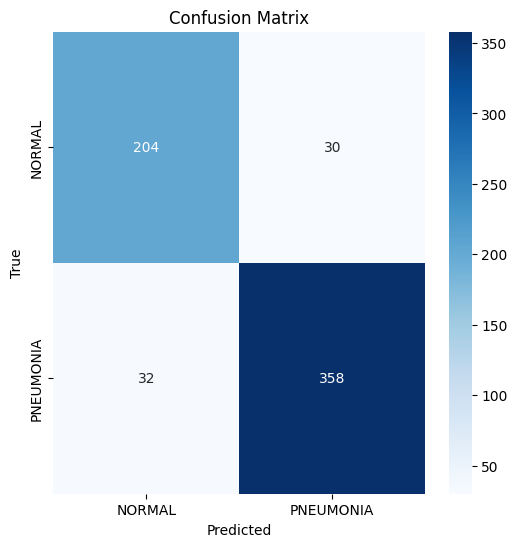

In [59]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Para clase NORMAL:
* Precision (NORMAL) = 204 / (204 + 32) = 0.864
* Recall (NORMAL) = 204 / (204 + 30) = 0.871
* F1-score (NORMAL) ‚âà 0.867

Para clase PNEUMONIA:
* Precision (PNEUMONIA) = 358 / (358 + 30) = 0.923
* Recall (PNEUMONIA) = 358 / (358 + 32) = 0.918
* F1-score (PNEUMONIA) ‚âà 0.921

Global:
* Accuracy total = (204 + 358) / 624 = 0.90 

## 9.10. Curva ROC.
### 9.10.1. Curva ROC con los datos de test.

In [60]:
print("Ejemplos en y_true:", len(y_true_val))
print("Ejemplos en y_pred_prob:", len(y_pred_prob))
print("Valores √∫nicos en y_true:", set(y_true_val))


Ejemplos en y_true: 624
Ejemplos en y_pred_prob: 624
Valores √∫nicos en y_true: {0.0, 1.0}


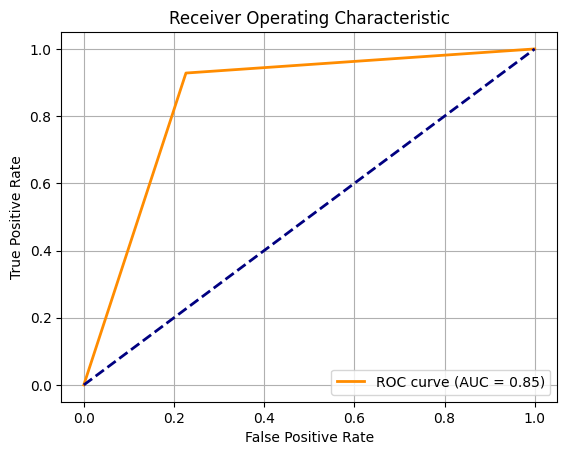

In [61]:
# Convertir a arrays

fpr, tpr, _ = roc_curve(y_true_val, y_pred_prob)  # usa las probabilidades, no etiquetas
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El modelo 5 (CNN profundo con Batch Normalization y Dropout) es el que ofrece mejor desempe√±o general, alcanzando un 90% de accuracy, un AUC de 0.85 y una matriz de confusi√≥n bastante equilibrada.

## 9.11 Distribuci√≥n de errores con los datos de test.

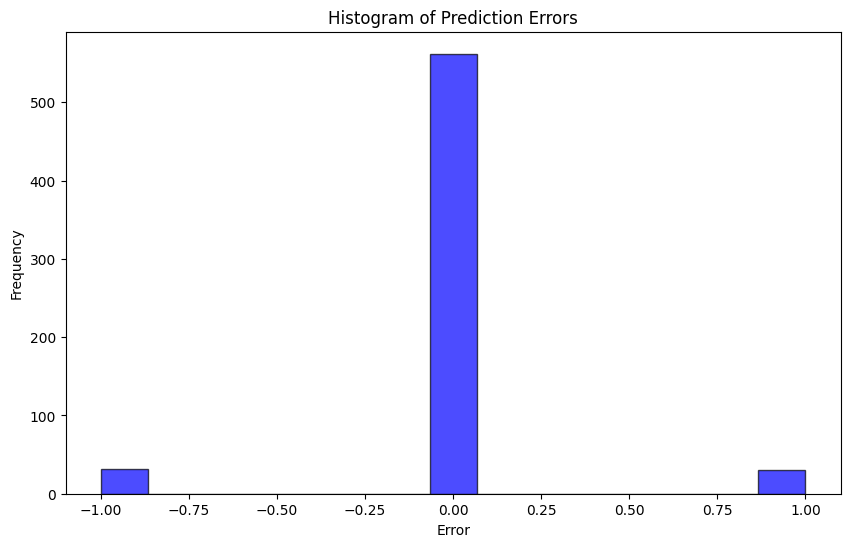

In [ ]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribuci√≥n de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

La gran mayor√≠a de los errores est√°n en el cero, lo que confirma el alto rendimiento general del modelo (coherente con el 90‚ÄØ% de accuracy).

In [63]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# √ötil si ya tienes la arquitectura definida por c√≥digo
model_5.save_weights('pesos_CNN2.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_5, "modelo_CNN2F")




INFO:tensorflow:Assets written to: modelo_CNN2F\assets


INFO:tensorflow:Assets written to: modelo_CNN2F\assets


In [64]:
from keras.layers import TFSMLayer

# Cargar como capa para predicci√≥n
modelo_inferencia = TFSMLayer("modelo_CNN2F", call_endpoint="serving_default")
